<a href="https://colab.research.google.com/github/samer-glitch/samerelhajjhassan/blob/main/Thesis%20%23overfitting%20dataleakage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

In [17]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.exceptions import ConvergenceWarning
from sklearn.tree import DecisionTreeClassifier  # Import missing classifier
import warnings


warnings.filterwarnings("ignore", category=ConvergenceWarning)

def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

def label_traffic_advanced(df):
    # Define adjusted thresholds based on typical network traffic characteristics
    normal_protocols = [6, 17, 1]  # TCP, UDP, and ICMP are common protocols
    normal_port_range = set(range(0, 65536))  # All ports are included
    normal_pkt_count_max = 50000  # A higher limit to account for active connections
    normal_octet_count_max = 5000000  # Increased to allow for larger data transfers
    normal_packet_size_range = range(0, 6000)  # Ethernet standard MTU size
    normal_flow_duration_range = range(0, 7200000)  # Extended to 2 hours
    normal_piat_range = range(0, 30000)  # Extended to 30 seconds
    max_timestamp = int(1e12)  # Assuming timestamp in milliseconds

    # Initialize the traffic_label column
    df['traffic_label'] = 'normal'

    # Iterate through each row
    for index, row in df.iterrows():
        # Check conditions for each feature
        if row['proto'] not in normal_protocols:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'proto' condition met")
            continue  # Move to the next row if the condition is met

        if row['flowEndReason'] == 1:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'flowEndReason' condition met")
            continue  # Move to the next row if the condition is met

        if row['src_port'] not in normal_port_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'src_port' condition met")
            continue  # Move to the next row if the condition is met

        if row['dst_port'] not in normal_port_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'dst_port' condition met")
            continue  # Move to the next row if the condition is met

        if row['pktTotalCount'] > normal_pkt_count_max:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'pktTotalCount' condition met")
            continue  # Move to the next row if the condition is met

        if row['octetTotalCount'] > normal_octet_count_max:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'octetTotalCount' condition met")
            continue  # Move to the next row if the condition is met

        if row['min_ps'] not in normal_packet_size_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'min_ps' condition met")
            continue  # Move to the next row if the condition is met

        if row['max_ps'] not in normal_packet_size_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'max_ps' condition met")
            continue  # Move to the next row if the condition is met

        if row['avg_ps'] not in normal_packet_size_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'avg_ps' condition met")

            continue  # Move to the next row if the condition is met


        if row['std_dev_ps'] not in normal_packet_size_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'std_dev_ps' condition met")
            continue  # Move to the next row if the condition is met

        if row['flowDuration'] not in normal_flow_duration_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'flowDuration' condition met")
            continue  # Move to the next row if the condition is met

        if row['min_piat'] not in normal_piat_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'min_piat' condition met")
            continue  # Move to the next row if the condition is met

        if row['max_piat'] not in normal_piat_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'max_piat' condition met")
            continue  # Move to the next row if the condition is met

        if row['avg_piat'] not in normal_piat_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'avg_piat' condition met")
            continue  # Move to the next row if the condition is met

        if row['std_dev_piat'] not in normal_piat_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'std_dev_piat' condition met")
            continue  # Move to the next row if the condition is met

        if row['flowStart'] < 0 or row['flowStart'] > max_timestamp:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'flowStart' condition met")
            continue  # Move to the next row if the condition is met

        if row['flowEnd'] < 0 or row['flowEnd'] > max_timestamp:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'flowEnd' condition met")
            continue  # Move to the next row if the condition is met

        if row['flowEnd'] < row['flowStart']:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'flowEnd' < 'flowStart' condition met")
            continue  # Move to the next row if the condition is met

        # Checks for 'f_' prefixed features
        if row['f_pktTotalCount'] > normal_pkt_count_max:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'f_pktTotalCount' condition met")
            continue  # Move to the next row if the condition is met

        if row['f_octetTotalCount'] > normal_octet_count_max:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'f_octetTotalCount' condition met")
            continue  # Move to the next row if the condition is met

        if row['f_min_ps'] not in normal_packet_size_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'f_min_ps' condition met")
            continue  # Move to the next row if the condition is met

        if row['f_max_ps'] not in normal_packet_size_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'f_max_ps' condition met")
            continue  # Move to the next row if the condition is met

        if row['f_avg_ps'] not in normal_packet_size_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'f_avg_ps' condition met")
            continue  # Move to the next row if the condition is met

        if row['f_std_dev_ps'] not in normal_packet_size_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'f_std_dev_ps' condition met")
            continue  # Move to the next row if the condition is met

        if row['f_flowDuration'] not in normal_flow_duration_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'f_flowDuration' condition met")
            continue  # Move to the next row if the condition is met

        if row['f_min_piat'] not in normal_piat_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'f_min_piat' condition met")
            continue  # Move to the next row if the condition is met

        if row['f_max_piat'] not in normal_piat_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'f_max_piat' condition met")
            continue  # Move to the next row if the condition is met

        if row['f_avg_piat'] not in normal_piat_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'f_avg_piat' condition met")
            continue  # Move to the next row if the condition is met

        if row['f_std_dev_piat'] not in normal_piat_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'f_std_dev_piat' condition met")
            continue  # Move to the next row if the condition is met

        # Checks for 'b_' prefixed features
        if row['b_pktTotalCount'] > normal_pkt_count_max:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'b_pktTotalCount' condition met")
            continue  # Move to the next row if the condition is met

        if row['b_octetTotalCount'] > normal_octet_count_max:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'b_octetTotalCount' condition met")
            continue  # Move to the next row if the condition is met

        if row['b_min_ps'] not in normal_packet_size_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'b_min_ps' condition met")
            continue  # Move to the next row if the condition is met

        if row['b_max_ps'] not in normal_packet_size_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'b_max_ps' condition met")
            continue  # Move to the next row if the condition is met

        if row['b_avg_ps'] not in normal_packet_size_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'b_avg_ps' condition met")
            continue  # Move to the next row if the condition is met

        if row['b_std_dev_ps'] not in normal_packet_size_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'b_std_dev_ps' condition met")
            continue  # Move to the next row if the condition is met

        if row['b_flowDuration'] not in normal_flow_duration_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'b_flowDuration' condition met")
            continue  # Move to the next row if the condition is met

        if row['b_min_piat'] not in normal_piat_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'b_min_piat' condition met")
            continue  # Move to the next row if the condition is met

        if row['b_max_piat'] not in normal_piat_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'b_max_piat' condition met")
            continue  # Move to the next row if the condition is met

        if row['b_avg_piat'] not in normal_piat_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'b_avg_piat' condition met")
            continue  # Move to the next row if the condition is met

        if row['b_std_dev_piat'] not in normal_piat_range:
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'b_std_dev_piat' condition met")
            continue  # Move to the next row if the condition is met

        # Add the new condition for category, application_protocol, and web_service
        if row['category'] == 'Unspecified' and row['application_protocol'] == 'Unknown' and row['web_service'] == 'Unknown':
            df.at[index, 'traffic_label'] = 'malicious'
            print(f"Row {index}: 'category', 'application_protocol', 'web_service' condition met")

    # Print the count of instances in each class after labeling
    label_counts = df['traffic_label'].value_counts()
    print("Label distribution after labeling:")
    print(label_counts)
    return df




# Load the dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-25000rows(ALLFEATURES).csv')
overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)


# Call your labeling function
df = label_traffic_advanced(df)
record_time("Labeling Function Applied", overall_start_time)

# Assuming 'traffic_label' is categorical and needs to be encoded
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])
record_time("Categorical Labels Encoded", overall_start_time)

# Drop columns
X = df.drop(columns=['traffic_label', 'category_encoded'])
y = df['category_encoded']
record_time("Features and Target Variable Defined", overall_start_time)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
record_time("Data Split into Train and Test Sets", overall_start_time)

non_numeric_columns = X_train.select_dtypes(exclude=[np.number]).columns
X_train = X_train.drop(non_numeric_columns, axis=1)
X_test = X_test.drop(non_numeric_columns, axis=1)
record_time("Non-numeric Columns Handled", overall_start_time)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
record_time("Preprocessing Applied", overall_start_time)

from sklearn.impute import SimpleImputer

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Apply imputation to the training data
X_train_imputed = imputer.fit_transform(X_train_scaled)

# Apply the same imputation to the test data
X_test_imputed = imputer.transform(X_test_scaled)

# Now apply SMOTE
#sm = SMOTE(random_state=42)
#X_train_res, y_train_res = sm.fit_resample(X_train_imputed, y_train)


# Models
# RandomForestClassifier adjustment
rf_clf = RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state=42)
# BaggingClassifier adjustment
bag_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
# LightGBMClassifier adjustment
lgbm_clf = LGBMClassifier(random_state=42, max_depth=6, min_data_in_leaf=20, num_leaves=31)
lr_clf = LogisticRegression(random_state=42)
ab_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=50, random_state=42)

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_clf),
        ('lgbm', lgbm_clf),
        ('rf', rf_clf),
        ('ab', ab_clf),
        ('gb', gb_clf),
        ('bag', bag_clf)
    ],
    voting='soft'
)

# Fit Models
for clf in (lr_clf, lgbm_clf, rf_clf, ab_clf, gb_clf, bag_clf, voting_clf):
    clf.fit(X_train_res, y_train_res)
    y_pred = clf.predict(X_test_scaled)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


# Hyperparameter tuning example for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train_res, y_train_res)
print("Best parameters for RandomForestClassifier:", CV_rfc.best_params_)

# Evaluation
def evaluate_model(model):
    y_pred = model.predict(X_test_scaled)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:,1])
    auc_score = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return conf_matrix, auc_score

for clf in (lr_clf, lgbm_clf, rf_clf, ab_clf, gb_clf, bag_clf, voting_clf):
    print(clf.__class__.__name__)
    conf_matrix, auc_score = evaluate_model(clf)
    print("Confusion Matrix:\n", conf_matrix)
    print("AUC Score:", auc_score)

print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)


Dataset Loaded - Time Elapsed: 0:00:00.000077


NameError: name 'avg_ps' is not defined

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES).csv to Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES).csv


In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings('ignore')

def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

def label_traffic_advanced(df):
    # Define normal thresholds based on typical network traffic characteristics in a university and a software company
    normal_protocols = {6, 17, 1}  # Common protocols: TCP, UDP, ICMP
    normal_port_range = set(range(0, 1024))  # Well-known ports, often targeted in attacks
    high_pkt_count_threshold = 10000  # High packet count could indicate scanning or DoS attacks
    high_data_volume_threshold = 10**7  # Threshold for data transfer volume (e.g., 10 MB)
    short_flow_duration_threshold = 500  # Very short flows (in ms) might be scans
    long_flow_duration_threshold = 3600000  # 1 hour, unusual long flows could be exfiltration
    suspicious_packet_size = 1500  # Standard MTU size for Ethernet, larger could be unusual
    high_inter_arrival_time = 1000  # Max acceptable packet inter-arrival time in ms
    low_inter_arrival_time = 10  # Min acceptable packet inter-arrival time in ms
    high_flow_rate = 10000  # Threshold for flow rate (packets per second)

    df['traffic_label'] = 'normal'

    for index, row in df.iterrows():
        # Check for uncommon protocols
        if row['proto'] not in normal_protocols:
            df.at[index, 'traffic_label'] = 'malicious'
            continue

        # Check for traffic on unusual ports
        if row['src_port'] not in normal_port_range or row['dst_port'] not in normal_port_range:
            df.at[index, 'traffic_label'] = 'malicious'
            continue

        # High packet counts and data volumes
        if row['pktTotalCount'] > high_pkt_count_threshold or row['octetTotalCount'] > high_data_volume_threshold:
            df.at[index, 'traffic_label'] = 'malicious'
            continue

        # Unusual flow durations
        if row['flowDuration'] < short_flow_duration_threshold or row['flowDuration'] > long_flow_duration_threshold:
            df.at[index, 'traffic_label'] = 'malicious'
            continue

        # Packet sizes and inter-arrival times
        if row['max_ps'] > suspicious_packet_size or row['min_ps'] > suspicious_packet_size:
            df.at[index, 'traffic_label'] = 'malicious'
            continue

        if row['avg_piat'] > high_inter_arrival_time or row['avg_piat'] < low_inter_arrival_time:
            df.at[index, 'traffic_label'] = 'malicious'
            continue

        # Flow rate
        if row['flowDuration'] > 0 and (row['pktTotalCount'] / (row['flowDuration'] / 1000)) > high_flow_rate:
            df.at[index, 'traffic_label'] = 'malicious'
            continue

        # Additional checks can be added based on more specific characteristics of network traffic

    return df


# Load and preprocess the dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-5000rows(ALLFEATURES).csv')
overall_start_time = datetime.datetime.now()

df = label_traffic_advanced(df)
record_time("Labeling Function Applied", overall_start_time)

label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])
record_time("Categorical Labels Encoded", overall_start_time)

# Prepare data for model training
X = df.drop(columns=['traffic_label', 'category_encoded'])
y = df['category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
record_time("Data Split into Train and Test Sets", overall_start_time)

# Impute and scale the data
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train[numeric_columns])
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_imputed = imputer.transform(X_test[numeric_columns])
X_test_scaled = scaler.transform(X_test_imputed)

# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

# Define and evaluate models using cross-validation
models = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state=42),
    "AdaBoostClassifier": AdaBoostClassifier(n_estimators=50, random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=50, random_state=42),
    "BaggingClassifier": BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42),
    "VotingClassifier": VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state=42)),
            ('ab', AdaBoostClassifier(n_estimators=50, random_state=42)),
            ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42)),
            ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42))
        ],
        voting='soft'
    )
}

for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_res, y_train_res, cv=5, scoring='accuracy')
    print(f"{model_name}: Mean CV Accuracy: {cv_scores.mean()}, Standard Deviation: {cv_scores.std()}")

# Best parameter tuning for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5)
CV_rfc.fit(X_train_res, y_train_res)
print("Best parameters for RandomForestClassifier:", CV_rfc.best_params_)

print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)

Labeling Function Applied - Time Elapsed: 0:00:00.794568
Categorical Labels Encoded - Time Elapsed: 0:00:00.797798
Data Split into Train and Test Sets - Time Elapsed: 0:00:00.808536
LogisticRegression: Mean CV Accuracy: 0.999874686716792, Standard Deviation: 0.00015347680092626088
RandomForestClassifier: Mean CV Accuracy: 1.0, Standard Deviation: 0.0
AdaBoostClassifier: Mean CV Accuracy: 1.0, Standard Deviation: 0.0
GradientBoostingClassifier: Mean CV Accuracy: 1.0, Standard Deviation: 0.0
BaggingClassifier: Mean CV Accuracy: 1.0, Standard Deviation: 0.0
VotingClassifier: Mean CV Accuracy: 1.0, Standard Deviation: 0.0


KeyboardInterrupt: 

In [ ]:
# Evaluate models and plot confusion matrices and ROC curves
for clf, name in [(lr_clf, 'Logistic Regression'), (rf_clf, 'Random Forest'), (ab_clf, 'AdaBoost'), (gb_clf, 'Gradient Boosting')]:
    # Predictions and probabilities
    y_pred = clf.predict(X_test_scaled)
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, name)

    # ROC curve
    plot_roc_curve(y_test, y_pred_proba, name)

# Calculate accuracy and F1-score for each model
lr_accuracy, lr_f1 = accuracy_score(y_test, lr_clf.predict(X_test_scaled)), f1_score(y_test, lr_clf.predict(X_test_scaled))
rf_accuracy, rf_f1 = accuracy_score(y_test, rf_clf.predict(X_test_scaled)), f1_score(y_test, rf_clf.predict(X_test_scaled))
ab_accuracy, ab_f1 = accuracy_score(y_test, ab_clf.predict(X_test_scaled)), f1_score(y_test, ab_clf.predict(X_test_scaled))
gb_accuracy, gb_f1 = accuracy_score(y_test, gb_clf.predict(X_test_scaled)), f1_score(y_test, gb_clf.predict(X_test_scaled))

# Print the results
print("\nLogistic Regression Classifier:\nAccuracy:", lr_accuracy, "\nF1-Score:", lr_f1)
print("\nRandom Forest Classifier:\nAccuracy:", rf_accuracy, "\nF1-Score:", rf_f1)
print("\nAdaBoost Classifier:\nAccuracy:", ab_accuracy, "\nF1-Score:", ab_f1)
print("\nGradient Boosting Classifier:\nAccuracy:", gb_accuracy, "\nF1-Score:", gb_f1)
print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)


NameError: name 'plot_confusion_matrix' is not defined

In [ ]:
# Print the count of instances in each class after labeling
label_counts = df['traffic_label'].value_counts()
print("Label distribution after labeling:")
print(label_counts)

print(df['category_encoded'].value_counts())


Label distribution after labeling:
malicious    8054
normal       1946
Name: traffic_label, dtype: int64
0    8054
1    1946
Name: category_encoded, dtype: int64


Statistics for avg_piat:
count     49.000000
mean      38.150012
std      119.770222
min        0.000000
25%        0.000659
50%        0.031510
75%       21.531847
max      600.021289
Name: avg_piat, dtype: float64

Statistics for min_piat:
count     49.000000
mean      24.949830
std      119.869693
min        0.000000
25%        0.000077
50%        0.000433
75%        0.000760
max      600.014446
Name: min_piat, dtype: float64

Statistics for max_piat:
count     49.000000
mean     104.284074
std      165.964596
min        0.000000
25%        0.000668
50%        0.379798
75%      198.656500
max      600.028202
Name: max_piat, dtype: float64


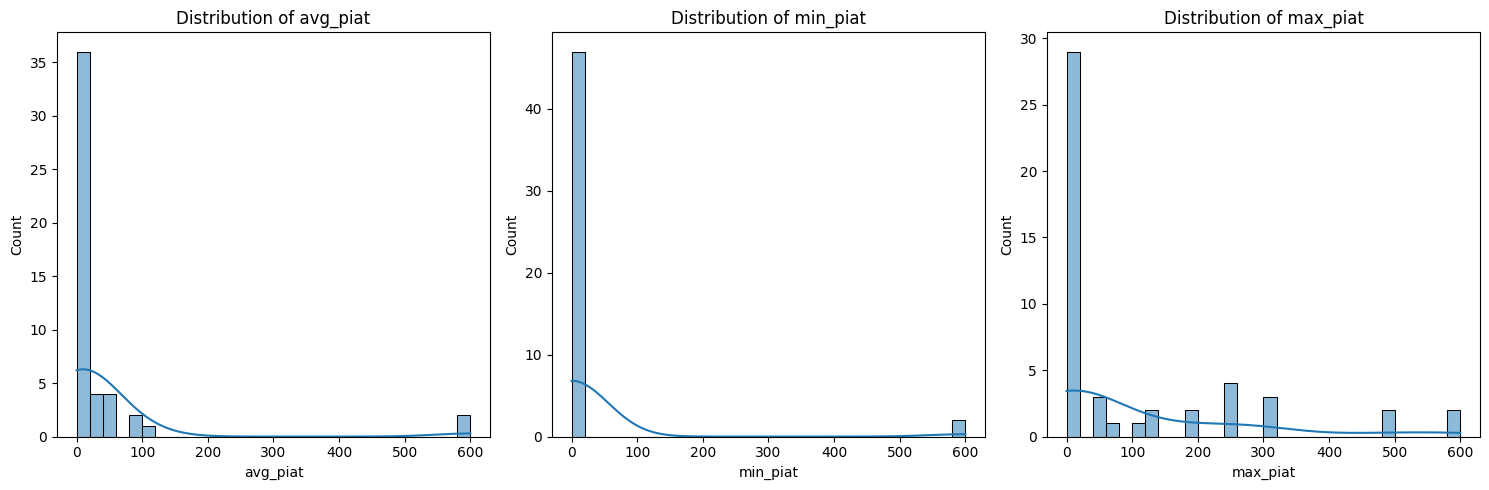

In [ ]:
# Display basic statistics
print("Statistics for avg_piat:")
print(df['avg_piat'].describe())

print("\nStatistics for min_piat:")
print(df['min_piat'].describe())

print("\nStatistics for max_piat:")
print(df['max_piat'].describe())
import seaborn as sns
# Plotting distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['avg_piat'], kde=True, bins=30)
plt.title('Distribution of avg_piat')

plt.subplot(1, 3, 2)
sns.histplot(df['min_piat'], kde=True, bins=30)
plt.title('Distribution of min_piat')

plt.subplot(1, 3, 3)
sns.histplot(df['max_piat'], kde=True, bins=30)
plt.title('Distribution of max_piat')

plt.tight_layout()
plt.show()

Statistics for avg_piat:
count      49.000000
mean      401.888065
std       665.791649
min         0.000000
25%         0.000668
50%         0.752857
75%       304.808016
max      1756.997627
Name: flowDuration, dtype: float64


Text(0.5, 1.0, 'Distribution of flowDuration')

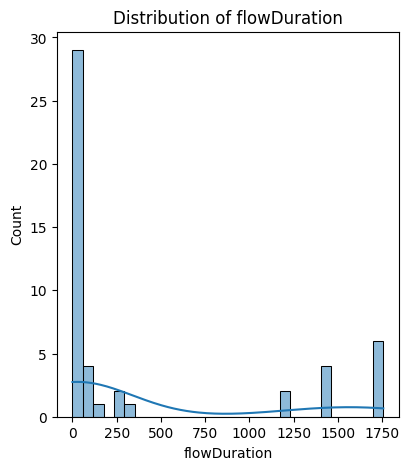

In [ ]:

# Display basic statistics
print("Statistics for flowDuration:")
print(df['flowDuration'].describe())


import seaborn as sns
# Plotting distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['flowDuration'], kde=True, bins=30)
plt.title('Distribution of flowDuration')

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

# Function to record the current time since the overall start
def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classifier_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {classifier_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, classifier_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {classifier_name}')
    plt.legend(loc='lower right')
    plt.show()

# Load the dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-50000rows(ALLFEATURES).csv')

# Start the overall timer
overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)

def label_traffic(df):
    # Define normal thresholds
    normal_protocols = [6, 17, 1]  # TCP and UDP
    normal_port_range = set(range(0, 49152))
    normal_pkt_count_max = 2000
    normal_octet_count_max = 1000000
    normal_packet_size_range = range(20, 1500)
    normal_flow_duration_range = range(50, 3600000)  # 50 ms to 1 hour
    normal_piat_range = range(0, 10000)  # 0 to 10 seconds
    max_timestamp = int(1e12)  # Assuming timestamp in milliseconds

    # Initialize the traffic_label column
    df['traffic_label'] = 'normal'

    # Vectorized conditions
# Vectorized conditions
    df.loc[~df['proto'].isin(normal_protocols), 'traffic_label'] = 'malicious'
    df.loc[df['flowEndReason'] == 1, 'traffic_label'] = 'malicious'
    df.loc[~df['src_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[~df['dst_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[df['pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
    df.loc[df['octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
    df.loc[~df['min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
    df.loc[~df['min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[(df['flowStart'] < 0) | (df['flowStart'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[(df['flowEnd'] < 0) | (df['flowEnd'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[df['flowEnd'] < df['flowStart'], 'traffic_label'] = 'malicious'

    # Process forward and backward flow features
    for prefix in ['f_', 'b_']:
        df.loc[df[prefix + 'pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
        df.loc[df[prefix + 'octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'

    # IP Address checks
    normal_src_ip_ranges = ['192.168.', '10.', '172.16.', '172.17.', '172.18.', '172.19.', '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.', '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']
    df.loc[df['src_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'
    df.loc[df['dst_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'

    # Web service, application protocol, and category checks
    normal_web_services = ['Google', 'Microsoft', 'HTTP', 'DNS', 'Amazon', 'MSN', 'TLS', 'Yahoo', 'DHCP', 'WindowsUpdate', 'NetBIOS', 'RX', 'MS_OneDrive', 'GMail', 'Dropbox', 'GoogleServices', 'ICMP']
    normal_application_protocols = ['HTTP', 'TLS', 'DNS', 'QUIC', 'IMAPS', 'STUN', 'SMTPS', 'POPS', 'Skype', 'SMBv23', 'NetBIOS', 'RDP', 'ApplePush', 'MQTT']
    normal_categories = ['Network', 'Web', 'SoftwareUpdate', 'RPC', 'System', 'Cloud', 'Mail', 'FTP', 'VPN', 'RemoteAccess']
    df.loc[~df['web_service'].isin(normal_web_services), 'traffic_label'] = 'malicious'
    df.loc[~df['application_protocol'].isin(normal_application_protocols), 'traffic_label'] = 'malicious'
    df.loc[~df['category'].isin(normal_categories), 'traffic_label'] = 'malicious'


    return df
# Apply the labeling function to the DataFrame
df = label_traffic(df)
record_time("Labeling Function Applied", overall_start_time)

# Encoding the categorical labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])
record_time("Categorical Labels Encoded", overall_start_time)

# Define features and target variable
X = df.drop(columns=['traffic_label', 'category_encoded'])
y = df['category_encoded']
record_time("Features and Target Variable Defined", overall_start_time)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
record_time("Data Split into Train and Test Sets", overall_start_time)

# Identify non-numeric columns
non_numeric_columns = X_train.select_dtypes(exclude=[np.number]).columns

# Remove non-numeric columns for simplicity
X_train = X_train.drop(non_numeric_columns, axis=1)
X_test = X_test.drop(non_numeric_columns, axis=1)
record_time("Non-numeric Columns Handled", overall_start_time)

# Apply preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
record_time("Preprocessing Applied", overall_start_time)

# Define and fit the classifiers
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
ab_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=50, random_state=42)

lr_clf.fit(X_train_scaled, y_train)
rf_clf.fit(X_train_scaled, y_train)
ab_clf.fit(X_train_scaled, y_train)
gb_clf.fit(X_train_scaled, y_train)
record_time("Classifiers Fitted", overall_start_time)

# Evaluate models and plot confusion matrices and ROC curves
for clf, name in [(lr_clf, 'Logistic Regression'), (rf_clf, 'Random Forest'), (ab_clf, 'AdaBoost'), (gb_clf, 'Gradient Boosting')]:
    # Predictions and probabilities
    y_pred = clf.predict(X_test_scaled)
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, name)

    # ROC curve
    plot_roc_curve(y_test, y_pred_proba, name)

# Calculate accuracy and F1-score for each model
lr_accuracy, lr_f1 = accuracy_score(y_test, lr_clf.predict(X_test_scaled)), f1_score(y_test, lr_clf.predict(X_test_scaled))
rf_accuracy, rf_f1 = accuracy_score(y_test, rf_clf.predict(X_test_scaled)), f1_score(y_test, rf_clf.predict(X_test_scaled))
ab_accuracy, ab_f1 = accuracy_score(y_test, ab_clf.predict(X_test_scaled)), f1_score(y_test, ab_clf.predict(X_test_scaled))
gb_accuracy, gb_f1 = accuracy_score(y_test, gb_clf.predict(X_test_scaled)), f1_score(y_test, gb_clf.predict(X_test_scaled))

# Print the results
print("\nLogistic Regression Classifier:\nAccuracy:", lr_accuracy, "\nF1-Score:", lr_f1)
print("\nRandom Forest Classifier:\nAccuracy:", rf_accuracy, "\nF1-Score:", rf_f1)
print("\nAdaBoost Classifier:\nAccuracy:", ab_accuracy, "\nF1-Score:", ab_f1)
print("\nGradient Boosting Classifier:\nAccuracy:", gb_accuracy, "\nF1-Score:", gb_f1)
print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Function to record the current time since the overall start
def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

# Start the overall timer
overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classifier_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {classifier_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, classifier_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {classifier_name}')
    plt.legend(loc='lower right')
    plt.show()

# Load dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-50000rows(ALLFEATURES).csv')
overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)

# Convert Unix timestamps to datetime objects
df['flowStart'] = pd.to_datetime(df['flowStart'], unit='s')
df['flowEnd'] = pd.to_datetime(df['flowEnd'], unit='s')
max_timestamp = pd.to_datetime('now')  # Define max_timestamp

# Extracting temporal features
df['flowStart_second'] = df['flowStart'].dt.second
df['flowStart_minute'] = df['flowStart'].dt.minute
df['flowStart_hour'] = df['flowStart'].dt.hour
df['flowStart_day_of_week'] = df['flowStart'].dt.weekday

df['flowEnd_second'] = df['flowEnd'].dt.second
df['flowEnd_minute'] = df['flowEnd'].dt.minute
df['flowEnd_hour'] = df['flowEnd'].dt.hour
df['flowEnd_day_of_week'] = df['flowEnd'].dt.weekday

df['flowDuration_hours'] = (df['flowDuration'] // 3600)
df['flowDuration_minutes'] = (df['flowDuration'] % 3600) // 60
df['flowDuration_seconds'] = df['flowDuration'] % 60

def label_traffic(df):
    # Define normal thresholds
    normal_protocols = [6, 17, 1]  # TCP and UDP
    normal_port_range = set(range(0, 49152))
    normal_pkt_count_max = 2000
    normal_octet_count_max = 1000000
    normal_packet_size_range = range(20, 1500)
    normal_flow_duration_range = range(50, 3600000)  # 50 ms to 1 hour
    normal_piat_range = range(0, 10000)  # 0 to 10 seconds

    # Initialize the traffic_label column
    df['traffic_label'] = 'normal'

    # Vectorized conditions
    df.loc[~df['proto'].isin(normal_protocols) | df['proto'].isna(), 'traffic_label'] = 'malicious'

    df.loc[df['flowEndReason'] == 1, 'traffic_label'] = 'malicious'
    df.loc[~df['src_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[~df['dst_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[df['pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
    df.loc[df['octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
    df.loc[~df['min_ps'].between(20, 1500), 'traffic_label'] = 'malicious'
    df.loc[~df['max_ps'].between(20, 1500), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_ps'].between(20, 1500), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_ps'].between(20, 1500), 'traffic_label'] = 'malicious'
    df.loc[~df['flowDuration'].between(50, 3600000), 'traffic_label'] = 'malicious'
    df.loc[~df['min_piat'].between(0, 10000), 'traffic_label'] = 'malicious'
    df.loc[~df['max_piat'].between(0, 10000), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_piat'].between(0, 10000), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_piat'].between(0, 10000), 'traffic_label'] = 'malicious'
    df.loc[(df['flowStart'] < pd.Timestamp('1970-01-01')) | (df['flowStart'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[(df['flowEnd'] < pd.Timestamp('1970-01-01')) | (df['flowEnd'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[df['flowEnd'] < df['flowStart'], 'traffic_label'] = 'malicious'

    # Process forward and backward flow features
    for prefix in ['f_', 'b_']:
        df.loc[df[prefix + 'pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
        df.loc[df[prefix + 'octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_ps'].between(20, 1500), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_ps'].between(20, 1500), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_ps'].between(20, 1500), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_ps'].between(20, 1500), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'flowDuration'].between(50, 3600000), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_piat'].between(0, 10000), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_piat'].between(0, 10000), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_piat'].between(0, 10000), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_piat'].between(0, 10000), 'traffic_label'] = 'malicious'

    # IP Address checks
    normal_src_ip_ranges = ['192.168.', '10.', '172.16.', '172.17.', '172.18.', '172.19.', '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.', '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']
    df['src_ip'] = df['src_ip'].astype(str)  # Ensure src_ip column is treated as strings
    df['dst_ip'] = df['dst_ip'].astype(str)  # Ensure dst_ip column is treated as strings
    df.loc[df['src_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'
    df.loc[df['dst_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'

    # Web service, application protocol, and category checks
    normal_web_services = ['Google', 'Microsoft', 'HTTP', 'DNS', 'Amazon', 'MSN', 'TLS', 'Yahoo', 'DHCP', 'WindowsUpdate', 'NetBIOS', 'RX', 'MS_OneDrive', 'GMail', 'Dropbox', 'GoogleServices', 'ICMP']
    normal_application_protocols = ['HTTP', 'TLS', 'DNS', 'QUIC', 'IMAPS', 'STUN', 'SMTPS', 'POPS', 'Skype', 'SMBv23', 'NetBIOS', 'RDP', 'ApplePush', 'MQTT']
    normal_categories = ['Network', 'Web', 'SoftwareUpdate', 'RPC', 'System', 'Cloud', 'Mail', 'FTP', 'Mining', 'VPN', 'RemoteAccess']
    df.loc[~df['web_service'].isin(normal_web_services), 'traffic_label'] = 'malicious'
    df.loc[~df['application_protocol'].isin(normal_application_protocols), 'traffic_label'] = 'malicious'
    df.loc[~df['category'].isin(normal_categories), 'traffic_label'] = 'malicious'

    return df

# Apply the labeling function to the DataFrame
df = label_traffic(df)
record_time("Labeling Function Applied", overall_start_time)

# Encoding categorical labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])
record_time("Categorical Labels Encoded", overall_start_time)

# Feature selection and splitting data
X = df.drop(columns=['traffic_label', 'category_encoded'])
y = df['category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
record_time("Data Split into Train and Test Sets", overall_start_time)

# Filter out non-numeric columns
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
X_train_numeric = X_train[numeric_columns]
X_test_numeric = X_test[numeric_columns]

# Handle missing values and scale data for numeric columns only
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train_numeric)
X_test_imputed = imputer.transform(X_test_numeric)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
record_time("Preprocessing Applied", overall_start_time)

# Define and fit classifiers
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
ab_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=50, random_state=42)


lr_clf.fit(X_train_scaled, y_train)
rf_clf.fit(X_train_scaled, y_train)
ab_clf.fit(X_train_scaled, y_train)
gb_clf.fit(X_train_scaled, y_train)
record_time("Classifiers Fitted", overall_start_time)

# Evaluate models and plot confusion matrices and ROC curves
for clf, name in [(lr_clf, 'Logistic Regression'), (rf_clf, 'Random Forest'), (ab_clf, 'AdaBoost'), (gb_clf, 'Gradient Boosting')]:
    y_pred = clf.predict(X_test_scaled)
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, name)
    plot_roc_curve(y_test, y_pred_proba, name)

# Calculate accuracy and F1-score for each model
lr_accuracy, lr_f1 = accuracy_score(y_test, lr_clf.predict(X_test_scaled)), f1_score(y_test, lr_clf.predict(X_test_scaled))
rf_accuracy, rf_f1 = accuracy_score(y_test, rf_clf.predict(X_test_scaled)), f1_score(y_test, rf_clf.predict(X_test_scaled))
ab_accuracy, ab_f1 = accuracy_score(y_test, ab_clf.predict(X_test_scaled)), f1_score(y_test, ab_clf.predict(X_test_scaled))
gb_accuracy, gb_f1 = accuracy_score(y_test, gb_clf.predict(X_test_scaled)), f1_score(y_test, gb_clf.predict(X_test_scaled))

# Print the results
print("\nLogistic Regression Classifier:\nAccuracy:", lr_accuracy, "\nF1-Score:", lr_f1)
print("\nRandom Forest Classifier:\nAccuracy:", rf_accuracy, "\nF1-Score:", rf_f1)
print("\nAdaBoost Classifier:\nAccuracy:", ab_accuracy, "\nF1-Score:", ab_f1)
print("\nGradient Boosting Classifier:\nAccuracy:", gb_accuracy, "\nF1-Score:", gb_f1)
print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)



In [ ]:
print(df['proto'].unique())


[17.  1.  6. nan]


In [ ]:
print(df[['flowStart', 'flowEnd', 'flowDuration']].head())


            flowStart             flowEnd  flowDuration
0 2019-04-22 17:18:51 2019-04-22 17:47:13   1701.385427
1 2019-04-22 17:18:51 2019-04-22 17:47:13   1701.385515
2 2019-04-22 20:06:14 2019-04-22 20:30:25   1450.967340
3 2019-04-22 20:06:14 2019-04-22 20:30:25   1450.967130
4 2019-04-22 20:54:59 2019-04-22 20:54:59      0.000000


In [ ]:
# Print the count of instances in each class after labeling
label_counts = df['traffic_label'].value_counts()
print("Label distribution after labeling:")
print(label_counts)

print(df['category_encoded'].value_counts())

print (" \n ")
print(df['traffic_label'].value_counts())


Label distribution after labeling:
malicious    9958
normal         42
Name: traffic_label, dtype: int64
0    9958
1      42
Name: category_encoded, dtype: int64
 
 
malicious    9958
normal         42
Name: traffic_label, dtype: int64


In [ ]:
print("Before Labeling:")
print(df['traffic_label'].value_counts())

# Apply the labeling function to the DataFrame
df = label_traffic(df)
record_time("Labeling Function Applied", overall_start_time)

print("After Labeling:")
print(df['traffic_label'].value_counts())


Before Labeling:
malicious    8054
normal       1946
Name: traffic_label, dtype: int64
Labeling Function Applied - Time Elapsed: 0:01:42.241708
After Labeling:
malicious    8054
normal       1946
Name: traffic_label, dtype: int64


In [ ]:
# Check the lengths of unique values arrays
web_services_length = len(unique_web_services)
application_protocols_length = len(unique_application_protocols)
categories_length = len(unique_categories)

# Print the lengths
print("Length of Unique Web Services:", web_services_length)
print("Length of Unique Application Protocols:", application_protocols_length)
print("Length of Unique Categories:", categories_length)
# Get unique values in the 'web_service' column
unique_web_services = df['web_service'].unique()

# Get unique values in the 'application_protocol' column
unique_application_protocols = df['application_protocol'].unique()

# Get unique values in the 'category' column
unique_categories = df['category'].unique()

# Print the unique values
print("Unique Web Services:")
print(unique_web_services)

print("\nUnique Application Protocols:")
print(unique_application_protocols)

print("\nUnique Categories:")
print(unique_categories)
# Existing normal lists
normal_web_services = ['Google', 'Microsoft', 'HTTP', 'DNS', 'Amazon', 'MSN', 'TLS', 'Yahoo', 'DHCP', 'WindowsUpdate', 'NetBIOS', 'RX', 'MS_OneDrive', 'GMail', 'Dropbox', 'GoogleServices', 'ICMP', 'UbuntuONE', 'GoogleDrive', 'YouTube', 'HTTP_Proxy', 'NTP', 'Apple', 'AppleiTunes', 'AppleStore', 'ApplePush', 'AppleiCloud', 'IMAPS', 'IMO', 'Office365', 'Skype', 'Cloudflare']
normal_application_protocols = ['HTTP', 'TLS', 'DNS', 'QUIC', 'IMAPS', 'STUN', 'SMTPS', 'POPS', 'Skype', 'SMBv23', 'NetBIOS', 'RDP', 'ApplePush', 'MQTT']

normal_categories = ['Network', 'Web', 'SoftwareUpdate', 'RPC', 'System', 'Cloud', 'Mail', 'FTP', 'Mining', 'VPN', 'RemoteAccess', 'Email', 'Media', 'Streaming', 'VoIP', 'Collaborative']

# Add missing values from Unique Web Services
for service in unique_web_services:
    if service not in normal_web_services and pd.notna(service):
        normal_web_services.append(service)

# Add missing values from Unique Application Protocols
for protocol in unique_application_protocols:
    if protocol not in normal_application_protocols and pd.notna(protocol):
        normal_application_protocols.append(protocol)

# Add missing values from Unique Categories
for category in unique_categories:
    if category not in normal_categories and pd.notna(category):
        normal_categories.append(category)

# Print the updated normal lists
print("Updated Normal Web Services:")
print(normal_web_services)

print("\nUpdated Normal Application Protocols:")
print(normal_application_protocols)

print("\nUpdated Normal Categories:")
print(normal_categories)


Length of Unique Web Services: 34
Length of Unique Application Protocols: 7
Length of Unique Categories: 13
Unique Web Services:
['DHCP' 'ICMP' 'HTTP' 'Microsoft' 'WindowsUpdate' 'Unknown' 'DNS' 'RX'
 'TLS' 'NetBIOS' 'GoogleServices' 'Amazon' 'MSN' 'Yahoo' 'MS_OneDrive'
 'Google' 'Dropbox' 'GMail' 'UbuntuONE' 'GoogleDrive' 'YouTube'
 'HTTP_Proxy' 'NTP' 'Apple' 'AppleiTunes' 'AppleStore' 'ApplePush'
 'AppleiCloud' 'IMAPS' 'IMO' 'Office365' 'Skype' 'Cloudflare' nan]

Unique Application Protocols:
['Unknown' 'HTTP' 'TLS' 'DNS' 'QUIC' 'IMAPS' nan]

Unique Categories:
['Network' 'Web' 'SoftwareUpdate' 'Unspecified' 'RPC' 'System' 'Cloud'
 'Email' 'Media' 'Streaming' 'VoIP' 'Collaborative' nan]
Updated Normal Web Services:
['Google', 'Microsoft', 'HTTP', 'DNS', 'Amazon', 'MSN', 'TLS', 'Yahoo', 'DHCP', 'WindowsUpdate', 'NetBIOS', 'RX', 'MS_OneDrive', 'GMail', 'Dropbox', 'GoogleServices', 'ICMP', 'UbuntuONE', 'GoogleDrive', 'YouTube', 'HTTP_Proxy', 'NTP', 'Apple', 'AppleiTunes', 'AppleStore', 

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# Function to record the current time since the overall start
def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

# Start the overall timer
overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classifier_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {classifier_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, classifier_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {classifier_name}')
    plt.legend(loc='lower right')
    plt.show()

# Load dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-50000rows(ALLFEATURES).csv')
overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)

# Convert Unix timestamps to datetime objects
df['flowStart'] = pd.to_datetime(df['flowStart'], unit='s')
df['flowEnd'] = pd.to_datetime(df['flowEnd'], unit='s')
max_timestamp = pd.to_datetime('now')  # Define max_timestamp

# Extracting temporal features
df['flowStart_second'] = df['flowStart'].dt.second
df['flowStart_minute'] = df['flowStart'].dt.minute
df['flowStart_hour'] = df['flowStart'].dt.hour
df['flowStart_day_of_week'] = df['flowStart'].dt.weekday

df['flowEnd_second'] = df['flowEnd'].dt.second
df['flowEnd_minute'] = df['flowEnd'].dt.minute
df['flowEnd_hour'] = df['flowEnd'].dt.hour
df['flowEnd_day_of_week'] = df['flowEnd'].dt.weekday

df['flowDuration_hours'] = (df['flowDuration'] // 3600)
df['flowDuration_minutes'] = (df['flowDuration'] % 3600) // 60
df['flowDuration_seconds'] = df['flowDuration'] % 60

print("Number of rows before labeling:", len(df))


def label_traffic_advanced(df):
    df['traffic_label'] = 'normal'

    # Feature Engineering
    df['src_dst_port_diff'] = abs(df['src_port'] - df['dst_port'])
    df['flow_duration_log'] = np.log(df['flowDuration'] + 1)
    df['high_octet_per_packet'] = df['octetTotalCount'] / (df['pktTotalCount'] + 1)

    # Define suspicious criteria
    # (These thresholds should be adjusted based on your network data analysis)
    suspicious_ports = set(range(49152, 65536))  # Dynamic/private ports
    pkt_count_threshold = 15000  # Increased threshold
    data_volume_threshold = 2*10**7  # Increased threshold
    short_flow_duration_threshold = 500  # in ms
    long_flow_duration_threshold = 3600000  # 1 hour
    unusual_packet_size_threshold = 1500  # Ethernet MTU size
    high_port_diff_threshold = 10000  # Large difference between src and dst ports
    high_octet_per_packet_threshold = 1500  # Abnormal octet-to-packet ratio

    for index, row in df.iterrows():
        # Conditions based on raw and engineered features
        if (
            row['src_port'] in suspicious_ports or
            row['dst_port'] in suspicious_ports or
            row['pktTotalCount'] > pkt_count_threshold or
            row['octetTotalCount'] > data_volume_threshold
            row['flowDuration'] < short_flow_duration_threshold or
            row['flowDuration'] > long_flow_duration_threshold or
            row['max_ps'] > unusual_packet_size_threshold or
            row['min_ps'] > unusual_packet_size_threshold or
            row['src_dst_port_diff'] > high_port_diff_threshold or
            row['high_octet_per_packet'] > high_octet_per_packet_threshold
        ):
            df.at[index, 'traffic_label'] = 'malicious'

    # Drop engineered features if they are not needed for further analysis
    df.drop(['src_dst_port_diff', 'flow_duration_log', 'high_octet_per_packet'], axis=1, inplace=True)

    return df

# Apply the advanced labeling function
df = label_traffic_advanced(df)
print("Label distribution after advanced labeling:")
print(df['traffic_label'].value_counts())




# Apply the labeling function to the DataFrame
df = label_traffic(df)
record_time("Labeling Function Applied", overall_start_time)

# Apply the labeling function
print("Number of rows after labeling:", len(df))

# Encoding categorical labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])
record_time("Categorical Labels Encoded", overall_start_time)

# Feature selection and splitting data
X = df.drop(columns=['traffic_label', 'category_encoded'])
y = df['category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
record_time("Data Split into Train and Test Sets", overall_start_time)

# Filter out non-numeric columns
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
X_train_numeric = X_train[numeric_columns]
X_test_numeric = X_test[numeric_columns]

# Handle missing values and scale data for numeric columns only
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train_numeric)
X_test_imputed = imputer.transform(X_test_numeric)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
record_time("Preprocessing Applied", overall_start_time)

# Define and fit classifiers
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
ab_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=50, random_state=42)

lr_clf.fit(X_train_scaled, y_train)
rf_clf.fit(X_train_scaled, y_train)
ab_clf.fit(X_train_scaled, y_train)
gb_clf.fit(X_train_scaled, y_train)
record_time("Classifiers Fitted", overall_start_time)

# Evaluate models and plot confusion matrices and ROC curves
for clf, name in [(lr_clf, 'Logistic Regression'), (rf_clf, 'Random Forest'), (ab_clf, 'AdaBoost'), (gb_clf, 'Gradient Boosting')]:
    y_pred = clf.predict(X_test_scaled)
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, name)
    plot_roc_curve(y_test, y_pred_proba, name)

# Calculate accuracy and F1-score for each model
lr_accuracy, lr_f1 = accuracy_score(y_test, lr_clf.predict(X_test_scaled)), f1_score(y_test, lr_clf.predict(X_test_scaled))
rf_accuracy, rf_f1 = accuracy_score(y_test, rf_clf.predict(X_test_scaled)), f1_score(y_test, rf_clf.predict(X_test_scaled))
ab_accuracy, ab_f1 = accuracy_score(y_test, ab_clf.predict(X_test_scaled)), f1_score(y_test, ab_clf.predict(X_test_scaled))
gb_accuracy, gb_f1 = accuracy_score(y_test, gb_clf.predict(X_test_scaled)), f1_score(y_test, gb_clf.predict(X_test_scaled))

# Print the results
print("\nLogistic Regression Classifier:\nAccuracy:", lr_accuracy, "\nF1-Score:", lr_f1)
print("\nRandom Forest Classifier:\nAccuracy:", rf_accuracy, "\nF1-Score:", rf_f1)
print("\nAdaBoost Classifier:\nAccuracy:", ab_accuracy, "\nF1-Score:", ab_f1)
print("\nGradient Boosting Classifier:\nAccuracy:", gb_accuracy, "\nF1-Score:", gb_f1)
print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)
print("Before Labeling:")
print(df['traffic_label'].value_counts())

# Apply the labeling function to the DataFrame
df = label_traffic(df)
record_time("Labeling Function Applied", overall_start_time)

print("After Labeling:")
print(df['traffic_label'].value_counts())

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-114-73480fa20b20>, line 93)

In [ ]:
print("Before Labeling:")
print(df['label_network_traffic'].value_counts())

# Apply the labeling function to the DataFrame
df = label_network_traffic(df)
record_time("Labeling Function Applied", overall_start_time)

print("After Labeling:")
print(df['label_network_traffic'].value_counts())

Before Labeling:


KeyError: 'label_network_traffic'

In [ ]:
df = label_network_traffic(df)
print("Label distribution after labeling:")
print(df['label_network_traffic'].value_counts())


Label distribution after labeling:


KeyError: 'label_network_traffic'

In [ ]:
def label_traffic_simple(df):
    df['traffic_label'] = 'normal'
    malicious_protocols = [6, 17, 1]  # TCP, UDP, ICMP
    for index, row in df.iterrows():
        if row['proto'] not in malicious_protocols:
            df.at[index, 'traffic_label'] = 'malicious'
    return df

df = label_traffic_simple(df)
print("Label distribution after simple labeling:")
print(df['traffic_label'].value_counts())


Label distribution after simple labeling:
normal    10000
Name: traffic_label, dtype: int64


In [ ]:
print("Unique protocols in the dataset:")
print(df['proto'].unique())


Unique protocols in the dataset:
[17  1  6]


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Unicauca-dataset-April-June-2019-Network-flows-50000rows(ALLFEATURES).csv to Unicauca-dataset-April-June-2019-Network-flows-50000rows(ALLFEATURES).csv


In [ ]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Function to record the current time since the overall start
def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

# Function to label network traffic
def label_network_traffic(df):
    df['traffic_label'] = 'normal'

    # Feature Engineering (if needed)
    df['src_dst_port_diff'] = abs(df['src_port'] - df['dst_port'])
    df['flow_duration_log'] = np.log(df['flowDuration'] + 1)
    df['high_octet_per_packet'] = df['octetTotalCount'] / (df['pktTotalCount'] + 1)

    # Adjusting thresholds to be less strict
    suspicious_ports = set(range(60000, 65536))  # Dynamic/private ports
    pkt_count_threshold = 150000  # Increased threshold for packet count
    data_volume_threshold = 2*10**7  # Increased threshold for data volume
    short_duration_threshold = 1000  # Increased threshold for short flow duration
    long_duration_threshold = 7200000  # Increased threshold for long flow duration (2 hours)
    unusual_packet_size_threshold = 20000  # Increased threshold for packet size
    high_port_diff_threshold = 20000  # Increased threshold for port difference
    high_octet_per_packet_threshold = 20000  # Increased threshold for octet-to-packet ratio

    for index, row in df.iterrows():
        if (
            row['src_port'] in suspicious_ports or
            row['dst_port'] in suspicious_ports or
            row['pktTotalCount'] > pkt_count_threshold or
            row['octetTotalCount'] > data_volume_threshold or
#            row['flowDuration'] < short_duration_threshold or
            row['flowDuration'] > long_duration_threshold or
            row['max_ps'] > unusual_packet_size_threshold or
            row['min_ps'] > unusual_packet_size_threshold or
#            row['src_dst_port_diff'] > high_port_diff_threshold or
            row['high_octet_per_packet'] > high_octet_per_packet_threshold
        ):
            df.at[index, 'traffic_label'] = 'malicious'

    # Clean up the DataFrame by removing engineered features
    df.drop(['src_dst_port_diff', 'flow_duration_log', 'high_octet_per_packet'], axis=1, inplace=True)

    return df

# Load dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES).csv')
overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)

# Apply the labeling function
df = label_network_traffic(df)
record_time("Labeling Function Applied", overall_start_time)
# Display the unique classes in the dataset
unique_classes = df['traffic_label'].unique()
print("Unique classes in the dataset:", unique_classes)


# Encoding categorical labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])
record_time("Categorical Labels Encoded", overall_start_time)

# Feature selection and splitting data
X = df.drop(columns=['traffic_label', 'category_encoded'])
y = df['category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
record_time("Data Split into Train and Test Sets", overall_start_time)

# Preprocessing: Handle missing values and scale data
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
X_train_numeric = X_train[numeric_columns]
X_test_numeric = X_test[numeric_columns]

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Apply imputation and scaling only to numeric data
X_train_imputed = imputer.fit_transform(X_train_numeric)
X_test_imputed = imputer.transform(X_test_numeric)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
record_time("Preprocessing Applied", overall_start_time)

# Define and fit classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, random_state=42)
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy}, F1 Score: {f1}")
    # Additional evaluation metrics can be added here

print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)


Dataset Loaded - Time Elapsed: 0:00:00.000053
Labeling Function Applied - Time Elapsed: 0:00:00.702583
Unique classes in the dataset: ['normal' 'malicious']
Categorical Labels Encoded - Time Elapsed: 0:00:00.708464
Data Split into Train and Test Sets - Time Elapsed: 0:00:00.722498
Preprocessing Applied - Time Elapsed: 0:00:00.781671
Logistic Regression - Accuracy: 0.992, F1 Score: 0.9949685534591195
Random Forest - Accuracy: 0.9995, F1 Score: 0.9996852376455775
AdaBoost - Accuracy: 0.9995, F1 Score: 0.9996852376455775
Gradient Boosting - Accuracy: 0.9995, F1 Score: 0.9996852376455775

Process Completed - Time: 0:00:04.531931


In [ ]:
# Print the count of instances in each class after labeling
label_counts = df['traffic_label'].value_counts()
print("Label distribution after labeling:")
print(label_counts)

print(df['category_encoded'].value_counts())

print (" \n ")
print(df['traffic_label'].value_counts())

Label distribution after labeling:
normal       7939
malicious    2061
Name: traffic_label, dtype: int64
1    7939
0    2061
Name: category_encoded, dtype: int64
 
 
normal       7939
malicious    2061
Name: traffic_label, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Function to record the current time since the overall start
def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

# Function to label network traffic
def label_network_traffic_updated(df):
    df['traffic_label'] = 'normal'

    # Define thresholds and suspicious indicators
    suspicious_ports = set(range(49152, 65536))  # Dynamic/private ports
    high_pkt_count_threshold = 5000
    high_data_volume_threshold = 5*10**6
    short_duration_threshold = 500  # Very short flows in milliseconds
    long_duration_threshold = 3600000  # 1 hour
    large_packet_size_threshold = 1500  # Larger than typical MTU size

    # Lists of services, protocols, and categories that might be suspicious
    suspicious_web_services = ['Unknown']
    suspicious_protocols = ['Unknown']
    suspicious_categories = ['Mining', 'RemoteAccess', 'Unspecified']

    for index, row in df.iterrows():
        # Combination of conditions for sophisticated detection
        if (
            (row['src_port'] in suspicious_ports or row['dst_port'] in suspicious_ports) or
            (row['pktTotalCount'] > high_pkt_count_threshold) or
            (row['octetTotalCount'] > high_data_volume_threshold) or
            (row['flowDuration'] < short_duration_threshold or row['flowDuration'] > long_duration_threshold) or
            (max(row['max_ps'], row['min_ps']) > large_packet_size_threshold) or
            (row['web_service'] in suspicious_web_services or row['application_protocol'] in suspicious_protocols or row['category'] in suspicious_categories) or
            (row['category'] == 'Network' and row['src_prefix'] != 'local' and row['dst_prefix'] != 'local') or
            (row['category'] == 'VPN' and row['src_prefix'] != 'local' and row['dst_prefix'] != 'local') or
            (row['category'] == 'RemoteAccess' and row['src_prefix'] != 'local' and row['dst_prefix'] != 'local')
        ):
            df.at[index, 'traffic_label'] = 'malicious'

    return df



# Load dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-50000rows(ALLFEATURES).csv')
overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)

# Apply the labeling function
df = label_network_traffic(df)
record_time("Labeling Function Applied", overall_start_time)
# Display the unique classes in the dataset
unique_classes = df['traffic_label'].unique()
print("Unique classes in the dataset:", unique_classes)


# Encoding categorical labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])
record_time("Categorical Labels Encoded", overall_start_time)

# Feature selection and splitting data
X = df.drop(columns=['traffic_label', 'category_encoded'])
y = df['category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
record_time("Data Split into Train and Test Sets", overall_start_time)

# Preprocessing: Handle missing values and scale data
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
X_train_numeric = X_train[numeric_columns]
X_test_numeric = X_test[numeric_columns]

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Apply imputation and scaling only to numeric data
X_train_imputed = imputer.fit_transform(X_train_numeric)
X_test_imputed = imputer.transform(X_test_numeric)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
record_time("Preprocessing Applied", overall_start_time)

# Define and fit classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, random_state=42)
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy}, F1 Score: {f1}")
    # Additional evaluation metrics can be added here

print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)


Dataset Loaded - Time Elapsed: 0:00:00.000081
Labeling Function Applied - Time Elapsed: 0:00:01.105822
Unique classes in the dataset: ['normal' 'malicious']
Categorical Labels Encoded - Time Elapsed: 0:00:01.116025
Data Split into Train and Test Sets - Time Elapsed: 0:00:01.132316
Preprocessing Applied - Time Elapsed: 0:00:01.213139
Logistic Regression - Accuracy: 0.992, F1 Score: 0.9949685534591195
Random Forest - Accuracy: 0.9995, F1 Score: 0.9996852376455775
AdaBoost - Accuracy: 0.9995, F1 Score: 0.9996852376455775
Gradient Boosting - Accuracy: 0.9995, F1 Score: 0.9996852376455775

Process Completed - Time: 0:00:05.309051


In [ ]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Function to record the current time since the overall start
def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classifier_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {classifier_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, classifier_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {classifier_name}')
    plt.legend(loc='lower right')
    plt.show()

# Function to label network traffic
def label_network_traffic_updated(df):
    df['traffic_label'] = 'normal'

    # Define thresholds and suspicious indicators
    suspicious_ports = set(range(49152, 65536))  # Dynamic/private ports
    high_pkt_count_threshold = 5000
    high_data_volume_threshold = 5*10**6
    short_duration_threshold = 500  # Very short flows in milliseconds
    long_duration_threshold = 3600000  # 1 hour
    large_packet_size_threshold = 1500  # Larger than typical MTU size

    # Lists of services, protocols, and categories that might be suspicious
    suspicious_web_services = ['Unknown']
    suspicious_protocols = ['Unknown']
    suspicious_categories = ['Mining', 'RemoteAccess', 'Unspecified']

    for index, row in df.iterrows():
        # Combination of conditions for sophisticated detection
        if (
            (row['src_port'] in suspicious_ports or row['dst_port'] in suspicious_ports) or
            (row['pktTotalCount'] > high_pkt_count_threshold) or
            (row['octetTotalCount'] > high_data_volume_threshold) or
            (row['flowDuration'] < short_duration_threshold or row['flowDuration'] > long_duration_threshold) or
            (max(row['max_ps'], row['min_ps']) > large_packet_size_threshold) or
            (row['web_service'] in suspicious_web_services or row['application_protocol'] in suspicious_protocols or row['category'] in suspicious_categories) or
            (row['category'] == 'Network' and row['src_prefix'] != 'local' and row['dst_prefix'] != 'local') or
            (row['category'] == 'VPN' and row['src_prefix'] != 'local' and row['dst_prefix'] != 'local') or
            (row['category'] == 'RemoteAccess' and row['src_prefix'] != 'local' and row['dst_prefix'] != 'local')
        ):
            df.at[index, 'traffic_label'] = 'malicious'

    return df

# Load dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-50000rows(ALLFEATURES).csv')
overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)

# Apply the labeling function
df = label_network_traffic_updated(df)
record_time("Labeling Function Applied", overall_start_time)
# Display the unique classes in the dataset
unique_classes = df['traffic_label'].unique()
print("Unique classes in the dataset:", unique_classes)

# Encoding categorical labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])
record_time("Categorical Labels Encoded", overall_start_time)

# Feature selection and splitting data
X = df.drop(columns=['traffic_label', 'category_encoded'])
y = df['category_encoded']

# Apply SMOTE for oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
record_time("Data Split into Train and Test Sets", overall_start_time)

# Preprocessing: Handle missing values and scale data
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
X_train_numeric = X_train[numeric_columns]
X_test_numeric = X_test[numeric_columns]

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Apply imputation and scaling only to numeric data
X_train_imputed = imputer.fit_transform(X_train_numeric)
X_test_imputed = imputer.transform(X_test_numeric)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
record_time("Preprocessing Applied", overall_start_time)

# Define classifiers and hyperparameter grids
classifiers = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'param_grid': {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(n_estimators=50, random_state=42),
        'param_grid': {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 10, 20, 30]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(n_estimators=50, random_state=42),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.001, 0.01, 0.1, 1]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(n_estimators=50, random_state=42),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.001, 0.01, 0.1, 1],
            'max_depth': [3, 4, 5]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
}

# Perform hyperparameter tuning and cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, classifier_info in classifiers.items():
    print(f"Training {name}...")
    clf = classifier_info['model']
    param_grid = classifier_info['param_grid']
    grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
    grid_search.fit(X_train_scaled, y_train)
    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{name} - Best Parameters: {grid_search.best_params_}")
    print(f"{name} - Accuracy: {accuracy}, F1 Score: {f1}")
    # Additional evaluation metrics can be added here

print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)


In [ ]:

from google.colab import files
uploaded = files.upload()

Saving Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES).csv to Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES) (1).csv


In [11]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

# Function to record the current time since the overall start
def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classifier_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {classifier_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, classifier_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {classifier_name}')
    plt.legend(loc='lower right')
    plt.show()

# Load the dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-25000rows(ALLFEATURES).csv')

# Start the overall timer
overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)

def label_traffic(df):
    # Define normal thresholds
    normal_protocols = [6, 17, 1]  # TCP and UDP
    normal_port_range = set(range(0, 49152))
    normal_pkt_count_max = 2000
    normal_octet_count_max = 1000000
    normal_packet_size_range = range(20, 1500)
    normal_flow_duration_range = range(50, 3600000)  # 50 ms to 1 hour
    normal_piat_range = range(0, 10000)  # 0 to 10 seconds
    max_timestamp = int(1e12)  # Assuming timestamp in milliseconds

    # Initialize the traffic_label column
    df['traffic_label'] = 'normal'

    # Vectorized conditions
# Vectorized conditions
    df.loc[~df['proto'].isin(normal_protocols), 'traffic_label'] = 'malicious'
    df.loc[df['flowEndReason'] == 1, 'traffic_label'] = 'malicious'
    df.loc[~df['src_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[~df['dst_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[df['pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
    df.loc[df['octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
    df.loc[~df['min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
    df.loc[~df['min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[(df['flowStart'] < 0) | (df['flowStart'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[(df['flowEnd'] < 0) | (df['flowEnd'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[df['flowEnd'] < df['flowStart'], 'traffic_label'] = 'malicious'

    # Process forward and backward flow features
    for prefix in ['f_', 'b_']:
        df.loc[df[prefix + 'pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
        df.loc[df[prefix + 'octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'

    # IP Address checks
    normal_src_ip_ranges = ['192.168.', '10.', '172.']
    df.loc[df['src_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'
    df.loc[df['dst_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'

    # Web service, application protocol, and category checks
    normal_web_services = ['Google', 'Microsoft', 'HTTP', 'DNS', 'Amazon', 'MSN', 'TLS', 'Yahoo', 'DHCP', 'WindowsUpdate', 'NetBIOS', 'RX', 'MS_OneDrive', 'GMail', 'Dropbox', 'GoogleServices', 'ICMP', 'UbuntuONE', 'GoogleDrive', 'YouTube', 'HTTP_Proxy', 'NTP', 'Apple', 'AppleiTunes', 'AppleStore', 'ApplePush', 'AppleiCloud', 'IMAPS', 'IMO', 'Office365', 'Skype', 'Cloudflare']
    normal_application_protocols = ['HTTP', 'TLS', 'DNS', 'QUIC', 'IMAPS', 'STUN', 'SMTPS', 'POPS', 'Skype', 'SMBv23', 'NetBIOS', 'RDP', 'ApplePush', 'MQTT']
    normal_categories = ['Network', 'Web', 'SoftwareUpdate', 'RPC', 'System', 'Cloud', 'Mail', 'FTP', 'VPN', 'RemoteAccess', 'Email', 'Media', 'Streaming', 'VoIP', 'Collaborative']

    df.loc[~df['web_service'].isin(normal_web_services), 'traffic_label'] = 'malicious'
    df.loc[~df['application_protocol'].isin(normal_application_protocols), 'traffic_label'] = 'malicious'
    df.loc[~df['category'].isin(normal_categories), 'traffic_label'] = 'malicious'


    return df
# Apply the labeling function to the DataFrame
df = label_traffic(df)
record_time("Labeling Function Applied", overall_start_time)

# Encoding the categorical labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])
record_time("Categorical Labels Encoded", overall_start_time)

# Define features and target variable
X = df.drop(columns=['traffic_label', 'category_encoded'])
y = df['category_encoded']
record_time("Features and Target Variable Defined", overall_start_time)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
record_time("Data Split into Train and Test Sets", overall_start_time)

# Identify non-numeric columns
non_numeric_columns = X_train.select_dtypes(exclude=[np.number]).columns

# Remove non-numeric columns for simplicity
X_train = X_train.drop(non_numeric_columns, axis=1)
X_test = X_test.drop(non_numeric_columns, axis=1)
record_time("Non-numeric Columns Handled", overall_start_time)

# Apply preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
record_time("Preprocessing Applied", overall_start_time)

# Define and fit the classifiers
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
ab_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=50, random_state=42)

lr_clf.fit(X_train_scaled, y_train)
dt_clf.fit(X_train_scaled, y_train)
rf_clf.fit(X_train_scaled, y_train)
ab_clf.fit(X_train_scaled, y_train)
gb_clf.fit(X_train_scaled, y_train)
record_time("Classifiers Fitted", overall_start_time)

# Evaluate models and plot confusion matrices and ROC curves
for clf, name in [(lr_clf, 'Logistic Regression'), (dt_clf, 'Decision Tree'), (rf_clf, 'Random Forest'), (ab_clf, 'AdaBoost'), (gb_clf, 'Gradient Boosting')]:
    # Predictions and probabilities
    y_pred = clf.predict(X_test_scaled)
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, name)

    # ROC curve
    plot_roc_curve(y_test, y_pred_proba, name)

# Calculate accuracy and F1-score for each model
lr_accuracy, lr_f1 = accuracy_score(y_test, lr_clf.predict(X_test_scaled)), f1_score(y_test, lr_clf.predict(X_test_scaled))
dt_accuracy, dt_f1 = accuracy_score(y_test, dt_clf.predict(X_test_scaled)), f1_score(y_test, dt_clf.predict(X_test_scaled)) # Decision Tree metrics
rf_accuracy, rf_f1 = accuracy_score(y_test, rf_clf.predict(X_test_scaled)), f1_score(y_test, rf_clf.predict(X_test_scaled))
ab_accuracy, ab_f1 = accuracy_score(y_test, ab_clf.predict(X_test_scaled)), f1_score(y_test, ab_clf.predict(X_test_scaled))
gb_accuracy, gb_f1 = accuracy_score(y_test, gb_clf.predict(X_test_scaled)), f1_score(y_test, gb_clf.predict(X_test_scaled))

# Print the results
print("\nLogistic Regression Classifier:\nAccuracy:", lr_accuracy, "\nF1-Score:", lr_f1)
print("\nDecision Tree Classifier:\nAccuracy:", dt_accuracy, "\nF1-Score:", dt_f1) # Decision Tree results
print("\nRandom Forest Classifier:\nAccuracy:", rf_accuracy, "\nF1-Score:", rf_f1)
print("\nAdaBoost Classifier:\nAccuracy:", ab_accuracy, "\nF1-Score:", ab_f1)
print("\nGradient Boosting Classifier:\nAccuracy:", gb_accuracy, "\nF1-Score:", gb_f1)
print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)

Dataset Loaded - Time Elapsed: 0:00:00.000062


AttributeError: 'float' object has no attribute 'startswith'

In [ ]:


# Method 1: Value Counts
print("Class distribution in y:")
print(y.value_counts())

print("\nClass distribution in y_train:")
print(y_train.value_counts())

# Method 2: Unique Values
print("\nUnique classes in y:")
print(np.unique(y))

print("\nUnique classes in y_train:")
print(np.unique(y_train))

Class distribution in y:
0    5359
1    4641
Name: category_encoded, dtype: int64

Class distribution in y_train:
0    4287
1    3713
Name: category_encoded, dtype: int64

Unique classes in y:
[0 1]

Unique classes in y_train:
[0 1]


In [ ]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Function to record the current time since the overall start
def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

# Load the dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES).csv')
overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)

def label_traffic(df):
    # Define normal thresholds
    normal_protocols = [6, 17, 1]  # TCP and UDP
    normal_port_range = set(range(0, 49152))
    normal_pkt_count_max = 2000
    normal_octet_count_max = 1000000
    normal_packet_size_range = range(20, 1500)
    normal_flow_duration_range = range(50, 3600000)  # 50 ms to 1 hour
    normal_piat_range = range(0, 10000)  # 0 to 10 seconds
    max_timestamp = int(1e12)  # Assuming timestamp in milliseconds

    # Initialize the traffic_label column
    df['traffic_label'] = 'normal'

    # Vectorized conditions
# Vectorized conditions
    df.loc[~df['proto'].isin(normal_protocols), 'traffic_label'] = 'malicious'
    df.loc[df['flowEndReason'] == 1, 'traffic_label'] = 'malicious'
    df.loc[~df['src_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[~df['dst_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[df['pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
    df.loc[df['octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
    df.loc[~df['min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
    df.loc[~df['min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[(df['flowStart'] < 0) | (df['flowStart'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[(df['flowEnd'] < 0) | (df['flowEnd'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[df['flowEnd'] < df['flowStart'], 'traffic_label'] = 'malicious'

    # Process forward and backward flow features
    for prefix in ['f_', 'b_']:
        df.loc[df[prefix + 'pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
        df.loc[df[prefix + 'octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'

    # IP Address checks
    normal_src_ip_ranges = ['192.168.', '10.', '172.16.', '172.17.', '172.18.', '172.19.', '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.', '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']
    df.loc[df['src_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'
    df.loc[df['dst_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'

    # Web service, application protocol, and category checks
    normal_web_services = ['Google', 'Microsoft', 'HTTP', 'DNS', 'Amazon', 'MSN', 'TLS', 'Yahoo', 'DHCP', 'WindowsUpdate', 'NetBIOS', 'RX', 'MS_OneDrive', 'GMail', 'Dropbox', 'GoogleServices', 'ICMP', 'UbuntuONE', 'GoogleDrive', 'YouTube', 'HTTP_Proxy', 'NTP', 'Apple', 'AppleiTunes', 'AppleStore', 'ApplePush', 'AppleiCloud', 'IMAPS', 'IMO', 'Office365', 'Skype', 'Cloudflare']
    normal_application_protocols = ['HTTP', 'TLS', 'DNS', 'QUIC', 'IMAPS', 'STUN', 'SMTPS', 'POPS', 'Skype', 'SMBv23', 'NetBIOS', 'RDP', 'ApplePush', 'MQTT']
    normal_categories = ['Network', 'Web', 'SoftwareUpdate', 'RPC', 'System', 'Cloud', 'Mail', 'FTP', 'VPN', 'RemoteAccess', 'Email', 'Media', 'Streaming', 'VoIP', 'Collaborative']

    df.loc[~df['web_service'].isin(normal_web_services), 'traffic_label'] = 'malicious'
    df.loc[~df['application_protocol'].isin(normal_application_protocols), 'traffic_label'] = 'malicious'
    df.loc[~df['category'].isin(normal_categories), 'traffic_label'] = 'malicious'


    return df

# Label the traffic data
df = label_traffic(df)
record_time("Labeling Function Applied", overall_start_time)

# Drop the specified columns
df = df.drop(columns=['flow_key', 'src_ip', 'dst_ip'])

# Encoding other non-numeric features
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])
df['application_protocol'] = label_encoder.fit_transform(df['application_protocol'])
df['web_service'] = label_encoder.fit_transform(df['web_service'])

# Encoding the categorical labels for traffic_label
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])
record_time("Categorical Labels Encoded", overall_start_time)
df['traffic_label_encoded'] = label_encoder.fit_transform(df['traffic_label'])


# Define features and target variable
X = df.drop(columns=['traffic_label', 'category_encoded'])
y = df['category_encoded']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
record_time("SMOTE Applied", overall_start_time)

# Impute and scale the data
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_train_imputed = imputer.fit_transform(X_train_res)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)

# Define classifiers and their hyperparameter grids
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42)
}

param_grids = {
    "LogisticRegression": {
        'C': [0.01, 0.1, 1, 10, 100],  # Range of regularization values
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [1000, 2000]  # Increased number of iterations
    },
    "DecisionTreeClassifier": {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "RandomForestClassifier": {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    "AdaBoostClassifier": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1]
    },
    "GradientBoostingClassifier": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 10]
    }
}

# Perform hyperparameter tuning for each classifier
best_params = {}
for name, clf in classifiers.items():
    grid_search = GridSearchCV(clf, param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train_res)
    best_params[name] = grid_search.best_params_
    print(f"Best parameters for {name}:", grid_search.best_params_)

# Train and evaluate each classifier with best parameters
for name, clf in classifiers.items():
    clf.set_params(**best_params[name])
    clf.fit(X_train_scaled, y_train_res)

    # Cross-validation
    cv_scores = cross_val_score(clf, X_train_scaled, y_train_res, cv=5, scoring='accuracy')
    print(f"{name}: Mean CV Accuracy: {cv_scores.mean()}, Standard Deviation: {cv_scores.std()}")

    # Predictions on test set
    y_pred = clf.predict(X_test_scaled)
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    # Print results
    print(f"\n{name} Classifier:")
    print("Accuracy:", accuracy, "\nF1-Score:", f1, "\nROC AUC:", roc)
    print("Confusion Matrix:\n", cm)

print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)




Dataset Loaded - Time Elapsed: 0:00:00.000074
Labeling Function Applied - Time Elapsed: 0:00:07.100518
Categorical Labels Encoded - Time Elapsed: 0:00:07.123719
SMOTE Applied - Time Elapsed: 0:00:07.300050


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best parameters for LogisticRegression: {'C': 100, 'max_iter': 2000, 'solver': 'sag'}
Best parameters for DecisionTreeClassifier: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}
Best parameters for AdaBoostClassifier: {'learning_rate': 1, 'n_estimators': 100}
Best parameters for GradientBoostingClassifier: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

LogisticRegression: Mean CV Accuracy: 0.9909031097019572, Standard Deviation: 0.0026737689663330587

LogisticRegression Classifier:
Accuracy: 0.9925 
F1-Score: 0.9919743178170143 
ROC AUC: 0.9979574112197633
Confusion Matrix:
 [[1058   14]
 [   1  927]]
DecisionTreeClassifier: Mean CV Accuracy: 0.9962664525720273, Standard Deviation: 0.005747477922595849

DecisionTreeClassifier Classifier:
Accuracy: 1.0 
F1-Score: 1.0 
ROC AUC: 1.0
Confusion Matrix:
 [[1072    0]
 [   0  928]]
RandomForestClassifier: Mean CV Accuracy: 0.9974341982167095, Standard Deviation: 0.0011424733583608338

RandomForestClassifier Classifier:
Accuracy: 0.9985 
F1-Score: 0.9983862291554599 
ROC AUC: 0.999961299375965
Confusion Matrix:
 [[1069    3]
 [   0  928]]
AdaBoostClassifier: Mean CV Accuracy: 0.9969665692581418, Standard Deviation: 0.00440335940618503

AdaBoostClassifier Classifier:
Accuracy: 1.0 
F1-Score: 1.0 
ROC AUC: 1.0
Confusion Matrix:
 [[1072    0]
 [   0  928]]
GradientBoostingClassifier: Mean CV Ac

In [ ]:

# Method 1: Value Counts
print("Class distribution in y:")
print(y.value_counts())

print("\nClass distribution in y_train:")
print(y_train.value_counts())

# Method 2: Unique Values
print("\nUnique classes in y:")
print(np.unique(y))

print("\nUnique classes in y_train:")
print(np.unique(y_train))

Class distribution in y:
0    5359
1    4641
Name: category_encoded, dtype: int64

Class distribution in y_train:
0    4287
1    3713
Name: category_encoded, dtype: int64

Unique classes in y:
[0 1]

Unique classes in y_train:
[0 1]


In [ ]:
# Encoding the target variable for correlation analysis
df_encoded = df.copy()
label_encoder = LabelEncoder()
df_encoded['traffic_label_encoded'] = label_encoder.fit_transform(df_encoded['traffic_label'])

# Dropping non-numeric columns for correlation analysis
df_encoded = df_encoded.select_dtypes(include=[np.number])

# Calculate correlations
correlations = df_encoded.corrwith(df_encoded['traffic_label_encoded']).sort_values(ascending=False)

# Display correlations
correlations.drop('traffic_label_encoded', inplace=True)  # Drop self-correlation
correlations
# Converting the correlations to a string for easy copying
correlations_str = correlations.to_string()
correlations_str


In [ ]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Function to record the current time since the overall start
def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

# Load the dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES).csv')
overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)

def label_traffic(df):
    # Define normal thresholds
    normal_protocols = [6, 17, 1]  # TCP and UDP
    normal_port_range = set(range(0, 49152))
    normal_pkt_count_max = 2000
    normal_octet_count_max = 1000000
    normal_packet_size_range = range(20, 1500)
    normal_flow_duration_range = range(50, 3600000)  # 50 ms to 1 hour
    normal_piat_range = range(0, 10000)  # 0 to 10 seconds
    max_timestamp = int(1e12)  # Assuming timestamp in milliseconds

    # Initialize the traffic_label column
    df['traffic_label'] = 'normal'

    # Vectorized conditions
    df.loc[~df['proto'].isin(normal_protocols), 'traffic_label'] = 'malicious'
    df.loc[df['flowEndReason'] == 1, 'traffic_label'] = 'malicious'
    df.loc[~df['src_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[~df['dst_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[df['pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
    df.loc[df['octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
    df.loc[~df['min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
    df.loc[~df['min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[(df['flowStart'] < 0) | (df['flowStart'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[(df['flowEnd'] < 0) | (df['flowEnd'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[df['flowEnd'] < df['flowStart'], 'traffic_label'] = 'malicious'

    # Process forward and backward flow features
    for prefix in ['f_', 'b_']:
        df.loc[df[prefix + 'pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
        df.loc[df[prefix + 'octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'

    # IP Address checks
    normal_src_ip_ranges = ['192.168.', '10.', '172.16.', '172.17.', '172.18.', '172.19.', '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.', '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']
    df.loc[df['src_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'
    df.loc[df['dst_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'

    # Web service, application protocol, and category checks
    normal_web_services = ['Google', 'Microsoft', 'HTTP', 'DNS', 'Amazon', 'MSN', 'TLS', 'Yahoo', 'DHCP', 'WindowsUpdate', 'NetBIOS', 'RX', 'MS_OneDrive', 'GMail', 'Dropbox', 'GoogleServices', 'ICMP', 'UbuntuONE', 'GoogleDrive', 'YouTube', 'HTTP_Proxy', 'NTP', 'Apple', 'AppleiTunes', 'AppleStore', 'ApplePush', 'AppleiCloud', 'IMAPS', 'IMO', 'Office365', 'Skype', 'Cloudflare']
    normal_application_protocols = ['HTTP', 'TLS', 'DNS', 'QUIC', 'IMAPS', 'STUN', 'SMTPS', 'POPS', 'Skype', 'SMBv23', 'NetBIOS', 'RDP', 'ApplePush', 'MQTT']
    normal_categories = ['Network', 'Web', 'SoftwareUpdate', 'RPC', 'System', 'Cloud', 'Mail', 'FTP', 'VPN', 'RemoteAccess', 'Email', 'Media', 'Streaming', 'VoIP', 'Collaborative']

    df.loc[~df['web_service'].isin(normal_web_services), 'traffic_label'] = 'malicious'
    df.loc[~df['application_protocol'].isin(normal_application_protocols), 'traffic_label'] = 'malicious'
    df.loc[~df['category'].isin(normal_categories), 'traffic_label'] = 'malicious'


    return df

# Label the traffic data
df = label_traffic(df)
record_time("Labeling Function Applied", overall_start_time)

# Drop the specified columns
df = df.drop(columns=['flow_key', 'src_ip', 'dst_ip'])

# Encoding other non-numeric features
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])
df['application_protocol'] = label_encoder.fit_transform(df['application_protocol'])
df['web_service'] = label_encoder.fit_transform(df['web_service'])

# Encoding the categorical labels for traffic_label
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])
record_time("Categorical Labels Encoded", overall_start_time)

# Define features and target variable
# Define X and Y
X = df.drop(columns=['flow_key', 'src_ip', 'dst_ip', 'traffic_label'])
y = df['traffic_label']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
record_time("SMOTE Applied", overall_start_time)

# Impute and scale the data
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_train_imputed = imputer.fit_transform(X_train_res)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)

# Define classifiers and their hyperparameter grids
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42)
}

param_grids = {
    "LogisticRegression": {
        'C': [0.01, 0.1, 1, 10, 100],  # Range of regularization values
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [1000, 2000]  # Increased number of iterations
    },
    "DecisionTreeClassifier": {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "RandomForestClassifier": {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    "AdaBoostClassifier": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1]
    },
    "GradientBoostingClassifier": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 10]
    }
}

# Perform hyperparameter tuning for each classifier
best_params = {}
for name, clf in classifiers.items():
    grid_search = GridSearchCV(clf, param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train_res)
    best_params[name] = grid_search.best_params_
    print(f"Best parameters for {name}:", grid_search.best_params_)

# Train and evaluate each classifier with best parameters
for name, clf in classifiers.items():
    clf.set_params(**best_params[name])
    clf.fit(X_train_scaled, y_train_res)

    # Cross-validation
    cv_scores = cross_val_score(clf, X_train_scaled, y_train_res, cv=5, scoring='accuracy')
    print(f"{name}: Mean CV Accuracy: {cv_scores.mean()}, Standard Deviation: {cv_scores.std()}")

    # Predictions on test set
    y_pred = clf.predict(X_test_scaled)
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    # Print results
    print(f"\n{name} Classifier:")
    print("Accuracy:", accuracy, "\nF1-Score:", f1, "\nROC AUC:", roc)
    print("Confusion Matrix:\n", cm)

print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)




In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Function to record the current time since the overall start
def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

# Load the dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-25000rows(ALLFEATURES).csv')
overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded", overall_start_time)

# Apply the labeling function to label the traffic data
def label_traffic(df):
    # Define normal thresholds
    normal_protocols = [6, 17, 1]  # TCP and UDP
    normal_port_range = set(range(0, 49152))
    normal_pkt_count_max = 2000
    normal_octet_count_max = 1000000
    normal_packet_size_range = range(20, 1500)
    normal_flow_duration_range = range(50, 3600000)  # 50 ms to 1 hour
    normal_piat_range = range(0, 10000)  # 0 to 10 seconds
    max_timestamp = int(1e12)  # Assuming timestamp in milliseconds

    # Initialize the traffic_label column
    df['traffic_label'] = 'normal'

    # Vectorized conditions
    df.loc[~df['proto'].isin(normal_protocols), 'traffic_label'] = 'malicious'
    df.loc[df['flowEndReason'] == 1, 'traffic_label'] = 'malicious'
    df.loc[~df['src_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[~df['dst_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[df['pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
    df.loc[df['octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
    df.loc[~df['min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
    df.loc[~df['min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[(df['flowStart'] < 0) | (df['flowStart'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[(df['flowEnd'] < 0) | (df['flowEnd'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[df['flowEnd'] < df['flowStart'], 'traffic_label'] = 'malicious'

    # Process forward and backward flow features
    for prefix in ['f_', 'b_']:
        df.loc[df[prefix + 'pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
        df.loc[df[prefix + 'octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'

    # IP Address checks
    normal_src_ip_ranges = ['192.168.', '10.', '172.16.', '172.17.', '172.18.', '172.19.', '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.', '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']
    df.loc[df['src_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'
    df.loc[df['dst_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'

    # Web service, application protocol, and category checks
    normal_web_services = ['Google', 'Microsoft', 'HTTP', 'DNS', 'Amazon', 'MSN', 'TLS', 'Yahoo', 'DHCP', 'WindowsUpdate', 'NetBIOS', 'RX', 'MS_OneDrive', 'GMail', 'Dropbox', 'GoogleServices', 'ICMP', 'UbuntuONE', 'GoogleDrive', 'YouTube', 'HTTP_Proxy', 'NTP', 'Apple', 'AppleiTunes', 'AppleStore', 'ApplePush', 'AppleiCloud', 'IMAPS', 'IMO', 'Office365', 'Skype', 'Cloudflare']
    normal_application_protocols = ['HTTP', 'TLS', 'DNS', 'QUIC', 'IMAPS', 'STUN', 'SMTPS', 'POPS', 'Skype', 'SMBv23', 'NetBIOS', 'RDP', 'ApplePush', 'MQTT']
    normal_categories = ['Network', 'Web', 'SoftwareUpdate', 'RPC', 'System', 'Cloud', 'Mail', 'FTP', 'VPN', 'RemoteAccess', 'Email', 'Media', 'Streaming', 'VoIP', 'Collaborative']

    df.loc[~df['web_service'].isin(normal_web_services), 'traffic_label'] = 'malicious'
    df.loc[~df['application_protocol'].isin(normal_application_protocols), 'traffic_label'] = 'malicious'
    df.loc[~df['category'].isin(normal_categories), 'traffic_label'] = 'malicious'


    return df

df = label_traffic(df)
record_time("Labeling Function Applied", overall_start_time)

# Drop the specified columns
df = df.drop(columns=['flow_key', 'src_ip', 'dst_ip'])

# Encoding other non-numeric features
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])
df['application_protocol'] = label_encoder.fit_transform(df['application_protocol'])
df['web_service'] = label_encoder.fit_transform(df['web_service'])

# Encoding the categorical labels for traffic_label
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])

# Remove the 'category' column
df = df.drop(columns=['category'])

# Define features and target variable
X = df.drop(columns=['traffic_label', 'category_encoded'])
y = df['category_encoded']


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
record_time("SMOTE Applied", overall_start_time)

# Impute and scale the data
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_train_imputed = imputer.fit_transform(X_train_res)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)

# Define classifiers and their hyperparameter grids
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42)
}

param_grids = {
    "LogisticRegression": {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [1000, 2000, 3000]  # Increase the number of iterations
    },

    "DecisionTreeClassifier": {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "RandomForestClassifier": {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    "AdaBoostClassifier": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1]
    },
    "GradientBoostingClassifier": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 10]
    }
}

# Perform hyperparameter tuning for each classifier
best_params = {}
for name, clf in classifiers.items():
    grid_search = GridSearchCV(clf, param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train_res)
    best_params[name] = grid_search.best_params_
    print(f"Best parameters for {name}:", grid_search.best_params_)

# Train and evaluate each classifier with best parameters
for name, clf in classifiers.items():
    clf.set_params(**best_params[name])
    clf.fit(X_train_scaled, y_train_res)

    # Cross-validation
    cv_scores = cross_val_score(clf, X_train_scaled, y_train_res, cv=5, scoring='accuracy')
    print(f"{name}: Mean CV Accuracy: {cv_scores.mean()}, Standard Deviation: {cv_scores.std()}")

# Predictions on test set
y_pred = clf.predict(X_test_scaled)
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# Print results
print(f"\n{name} Classifier:")
print("Accuracy:", accuracy, "\nF1-Score:", f1, "\nROC AUC:", roc)
print("Confusion Matrix:\n", cm)
print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)


Dataset Loaded - Time Elapsed: 0:00:00.000047


AttributeError: 'float' object has no attribute 'startswith'

In [ ]:
# Method 1: Value Counts
print("Class distribution in y:")
print(y.value_counts())

print("\nClass distribution in y_train:")
print(y_train.value_counts())

# Method 2: Unique Values
print("\nUnique classes in y:")
print(np.unique(y))

print("\nUnique classes in y_train:")
print(np.unique(y_train))

Class distribution in y:
malicious    10000
Name: traffic_label, dtype: int64

Class distribution in y_train:
malicious    8000
Name: traffic_label, dtype: int64

Unique classes in y:


NameError: name 'np' is not defined

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")
# Apply the labeling function to label the traffic data
def label_traffic(df):
    # Define normal thresholds
    normal_protocols = [6, 17, 1]  # TCP and UDP
    normal_port_range = set(range(0, 49152))
    normal_pkt_count_max = 2000
    normal_octet_count_max = 1000000
    normal_packet_size_range = range(20, 1500)
    normal_flow_duration_range = range(50, 3600000)  # 50 ms to 1 hour
    normal_piat_range = range(0, 10000)  # 0 to 10 seconds
    max_timestamp = int(1e12)  # Assuming timestamp in milliseconds

    # Initialize the traffic_label column
    df['traffic_label'] = 'normal'

    # Vectorized conditions
    df.loc[~df['proto'].isin(normal_protocols), 'traffic_label'] = 'malicious'
    df.loc[df['flowEndReason'] == 1, 'traffic_label'] = 'malicious'
    df.loc[~df['src_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[~df['dst_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[df['pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
    df.loc[df['octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
    df.loc[~df['min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
    df.loc[~df['min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[(df['flowStart'] < 0) | (df['flowStart'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[(df['flowEnd'] < 0) | (df['flowEnd'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[df['flowEnd'] < df['flowStart'], 'traffic_label'] = 'malicious'

    # Process forward and backward flow features
    for prefix in ['f_', 'b_']:
        df.loc[df[prefix + 'pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
        df.loc[df[prefix + 'octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'

    # IP Address checks
    normal_src_ip_ranges = ['192.168.', '10.', '172.16.', '172.17.', '172.18.', '172.19.', '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.', '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']
    df.loc[df['src_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'
    df.loc[df['dst_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'

    # Web service, application protocol, and category checks
    normal_web_services = ['Google', 'Microsoft', 'HTTP', 'DNS', 'Amazon', 'MSN', 'TLS', 'Yahoo', 'DHCP', 'WindowsUpdate', 'NetBIOS', 'RX', 'MS_OneDrive', 'GMail', 'Dropbox', 'GoogleServices', 'ICMP', 'UbuntuONE', 'GoogleDrive', 'YouTube', 'HTTP_Proxy', 'NTP', 'Apple', 'AppleiTunes', 'AppleStore', 'ApplePush', 'AppleiCloud', 'IMAPS', 'IMO', 'Office365', 'Skype', 'Cloudflare']
    normal_application_protocols = ['HTTP', 'TLS', 'DNS', 'QUIC', 'IMAPS', 'STUN', 'SMTPS', 'POPS', 'Skype', 'SMBv23', 'NetBIOS', 'RDP', 'ApplePush', 'MQTT']
    normal_categories = ['Network', 'Web', 'SoftwareUpdate', 'RPC', 'System', 'Cloud', 'Mail', 'FTP', 'VPN', 'RemoteAccess', 'Email', 'Media', 'Streaming', 'VoIP', 'Collaborative']

    df.loc[~df['web_service'].isin(normal_web_services), 'traffic_label'] = 'malicious'
    df.loc[~df['application_protocol'].isin(normal_application_protocols), 'traffic_label'] = 'malicious'
    df.loc[~df['category'].isin(normal_categories), 'traffic_label'] = 'malicious'


    return df

# Load your dataset here (replace 'your_dataset.csv' with the actual file path)
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES).csv')

# Apply the labeling function to label the traffic data
df = label_traffic(df)

# Preprocessing
# Encode non-numeric features using Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['src_ip', 'dst_ip', 'proto', 'application_protocol', 'web_service', 'traffic_label']
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Define features (X) and target variable (y)
X = df.drop(columns=['flow_key', 'traffic_label', 'flowEndReason', 'category'])
y = df['traffic_label']

# Standardize numeric features
scaler = StandardScaler()
# Define the numeric columns you want to standardize
numeric_columns = ['src_ip_numeric', 'src_port', 'dst_port', 'pktTotalCount', 'octetTotalCount',
                   'min_ps', 'max_ps', 'avg_ps', 'std_dev_ps', 'flowStart', 'flowEnd', 'flowDuration', 'min_piat',
                   'max_piat', 'avg_piat', 'std_dev_piat', 'f_pktTotalCount', 'f_octetTotalCount', 'f_min_ps',
                   'f_max_ps', 'f_avg_ps', 'f_std_dev_ps', 'f_flowStart', 'f_flowEnd', 'f_flowDuration', 'f_min_piat',
                   'f_max_piat', 'f_avg_piat', 'f_std_dev_piat', 'b_pktTotalCount', 'b_octetTotalCount', 'b_min_ps',
                   'b_max_ps', 'b_avg_ps', 'b_std_dev_ps', 'b_flowStart', 'b_flowEnd', 'b_flowDuration', 'b_min_piat',
                   'b_max_piat', 'b_avg_piat', 'b_std_dev_piat']

# Filter only the existing numeric columns in the DataFrame
numeric_columns = [col for col in numeric_columns if col in X.columns]

# Standardize the numeric features
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the Logistic Regression model
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# Predict using the Logistic Regression model
y_pred_lr = logistic_regression.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
roc_auc_lr = roc_auc_score(y_test, logistic_regression.predict_proba(X_test)[:, 1])
confusion_lr = confusion_matrix(y_test, y_pred_lr)

# Print evaluation metrics for Logistic Regression
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_lr)
print("F1-Score:", f1_lr)
print("ROC AUC:", roc_auc_lr)
print("Confusion Matrix:\n", confusion_lr)

# Create and train the RandomForestClassifier model
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

# Predict using the RandomForestClassifier model
y_pred_rf = random_forest.predict(X_test)

# Evaluate the RandomForestClassifier model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
roc_auc_rf = roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1])
confusion_rf = confusion_matrix(y_test, y_pred_rf)

# Print evaluation metrics for RandomForestClassifier
print("\nRandom Forest Classifier Metrics:")
print("Accuracy:", accuracy_rf)
print("F1-Score:", f1_rf)
print("ROC AUC:", roc_auc_rf)
print("Confusion Matrix:\n", confusion_rf)


Logistic Regression Metrics:
Accuracy: 0.9755
F1-Score: 0.9755008803757006
ROC AUC: 0.9956424102547606
Confusion Matrix:
 [[1047   25]
 [  24  904]]

Random Forest Classifier Metrics:
Accuracy: 0.9985
F1-Score: 0.9985001594173439
ROC AUC: 0.9996743116314977
Confusion Matrix:
 [[1069    3]
 [   0  928]]


In [ ]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
print(missing_values)


flow_key                0
src_ip_numeric          0
src_ip                  0
src_port                0
dst_ip                  0
dst_port                0
proto                   0
pktTotalCount           0
octetTotalCount         0
min_ps                  0
max_ps                  0
avg_ps                  0
std_dev_ps              0
flowStart               0
flowEnd                 0
flowDuration            0
min_piat                0
max_piat                0
avg_piat                0
std_dev_piat            0
f_pktTotalCount         0
f_octetTotalCount       0
f_min_ps                0
f_max_ps                0
f_avg_ps                0
f_std_dev_ps            0
f_flowStart             0
f_flowEnd               0
f_flowDuration          0
f_min_piat              0
f_max_piat              0
f_avg_piat              0
f_std_dev_piat          0
b_pktTotalCount         0
b_octetTotalCount       0
b_min_ps                0
b_max_ps                0
b_avg_ps                0
b_std_dev_ps

In [ ]:
import socket
import struct

# Function to convert IP address from numeric format to dotted format
def numeric_to_dotted_ip(numeric_ip):
    try:
        return socket.inet_ntoa(struct.pack('!I', numeric_ip))
    except:
        return None

# Test the conversion with an example from the dataset
example_numeric_ip = 3232266497
converted_ip = numeric_to_dotted_ip(example_numeric_ip)
print(converted_ip)

192.168.121.1


In [40]:
from google.colab import files
uploaded = files.upload()

Saving Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES).csv to Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES).csv


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Function to record the current time since the overall start
def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

# Apply the modified labeling function to label the traffic data
def label_traffic(df):
    # Define normal thresholds
    normal_protocols = [6, 17, 1]  # TCP and UDP
    normal_port_range = set(range(0, 65536)) #65536   49152
    normal_pkt_count_max = 50
    normal_octet_count_max = 15000
    normal_packet_size_range = range(20, 1500)
    normal_piat_range = range(0, 248)  # 0 to  seconds
    max_timestamp = int(1e12)  # Assuming timestamp in milliseconds
    normal_std_dev_ps_range = range(9, 27)
    normal_flow_duration_range = range(1451, 1702)
    normal_min_piat_range = range(0, int(0.010356 * 1e6))  # Converting to microseconds if necessary
    normal_max_piat_range = range(158, 249)  # Based on max_piat analysis
    normal_avg_piat_range = range(1, 107)  # Based on avg_piat analysis
    normal_std_dev_piat_range = range(50, 79)  # Based on std_dev_piat analysis

    # Initialize the traffic_label column
    df['traffic_label'] = 'normal'

    # Vectorized conditions
    df.loc[~df['proto'].isin(normal_protocols), 'traffic_label'] = 'malicious'
    df.loc[df['flowEndReason'] == 1, 'traffic_label'] = 'malicious'
    df.loc[~df['src_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[~df['dst_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[df['pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
    df.loc[df['octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
    df.loc[~df['min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
    df.loc[~df['min_piat'].isin(normal_min_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_piat'].isin(normal_max_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_piat'].isin(normal_avg_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_piat'].isin(normal_std_dev_piat_range), 'traffic_label'] = 'malicious'

    df.loc[(df['flowStart'] < 0) | (df['flowStart'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[(df['flowEnd'] < 0) | (df['flowEnd'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[df['flowEnd'] < df['flowStart'], 'traffic_label'] = 'malicious'

    # Process forward and backward flow features
    for prefix in ['f_', 'b_']:
        df.loc[df[prefix + 'pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
        df.loc[df[prefix + 'octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'

    # IP Address checks
    normal_src_ip_ranges = ['192.168.', '10.', '172.16.', '172.17.', '172.18.', '172.19.', '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.', '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']
    # Convert 'src_ip' and 'dst_ip' columns to strings
    df['src_ip'] = df['src_ip'].astype(str)
    df['dst_ip'] = df['dst_ip'].astype(str)

    # Then apply your existing conditions
    df.loc[df['src_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'
    df.loc[df['dst_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'


    # Web service, application protocol, and category checks
    normal_web_services = ['DHCP', 'ICMP', 'HTTP', 'Microsoft', 'WindowsUpdate', 'Unknown', 'DNS', 'RX', 'TLS', 'NetBIOS', 'GoogleServices', 'Amazon', 'MSN', 'Yahoo', 'MS_OneDrive', 'Google', 'Dropbox', 'GMail', 'UbuntuONE', 'GoogleDrive', 'YouTube', 'HTTP_Proxy', 'NTP', 'Apple', 'AppleiTunes', 'AppleStore', 'ApplePush', 'AppleiCloud', 'IMAPS', 'IMO', 'Office365', 'Skype', 'Cloudflare', 'Spotify', 'LDAP', 'Twitter', 'Facebook', 'LinkedIn', 'Instagram', 'AmazonVideo', 'GooglePlus', 'Github', 'GoogleDocs', 'Teredo', 'BitTorrent', 'Messenger', 'WhatsApp', 'PlayStore', 'Ookla', 'Unencrypted_Jabber', 'SMBv23', 'Wikipedia', 'QUIC', 'Signal', 'CiscoVPN', 'TeamViewer', 'VNC', 'NetFlix', 'Playstation', 'PS_VUE', 'Xbox', 'GoogleMaps', 'GoogleHangoutDuo', 'MQTT', 'Radius', 'SSH', 'STUN', 'Pando_Media_Booster', 'Whois-DAS', 'H323', 'Webex', 'Oracle', 'DataSaver', 'Steam', 'SNMP', 'WhatsAppCall', 'Syslog', 'Starcraft', 'IPsec', 'SIP', 'RDP', 'MsSQL-TDS', 'OpenDNS', 'SkypeCall', 'Tor', 'RTMP', 'QQ', 'IRC', 'Slack', 'eBay', 'HotspotShield', 'TikTok', 'Snapchat', 'SSDP', 'DNSoverHTTPS', 'SMTP', 'RTP']
    normal_application_protocols = ['Unknown', 'HTTP', 'TLS', 'DNS', 'QUIC', 'IMAPS', 'STUN', 'SMTPS', 'POPS', 'Skype', 'SMBv23']
    normal_categories = ['Network', 'Web', 'SoftwareUpdate', 'Unspecified', 'RPC', 'System', 'Cloud', 'Email', 'Media', 'Streaming', 'VoIP', 'Collaborative', 'Music', 'SocialNetwork', 'Video', 'Download-FileTransfer-FileSharing', 'Chat', 'VPN', 'RemoteAccess', 'Game', 'Database', 'Shopping']

    df.loc[~df['web_service'].isin(normal_web_services), 'traffic_label'] = 'malicious'
    df.loc[~df['application_protocol'].isin(normal_application_protocols), 'traffic_label'] = 'malicious'
    df.loc[~df['category'].isin(normal_categories), 'traffic_label'] = 'malicious'


    return df

# Load your dataset here (replace 'your_dataset.csv' with the actual file path)
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-25000rows(ALLFEATURES).csv')
record_time("Dataset Loaded", overall_start_time)

# Apply the modified labeling function to label the traffic data
df = label_traffic(df)
record_time("Labeling Function Applied", overall_start_time)

# Modified preprocessing step
# Identify all categorical columns (excluding the target variable)
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('traffic_label')

# Apply label encoding to each categorical column
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])
record_time("Categorical Labels Encoded", overall_start_time)

# Define features (X) and target variable (y)
#X = df.drop(columns=['flow_key', 'traffic_label', 'src_ip', 'min_ps' , 'max_ps', 'avg_ps', 'std_dev_ps']))
X = df.drop(columns=['flow_key', 'traffic_label', 'src_ip'])
y = df['traffic_label']

# Handle NaN values by imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize numeric features
scaler = StandardScaler()
# Define the numeric columns you want to standardize
# Define the numeric columns you want to standardize
numeric_columns = [
    'src_ip_numeric', 'src_port', 'dst_port', 'pktTotalCount', 'octetTotalCount',
    'min_ps', 'max_ps', 'avg_ps', 'std_dev_ps', 'flowStart', 'flowEnd',
    'flowDuration', 'min_piat', 'max_piat', 'avg_piat', 'std_dev_piat',
    'f_pktTotalCount', 'f_octetTotalCount', 'f_min_ps', 'f_max_ps', 'f_avg_ps',
    'f_std_dev_ps', 'f_flowStart', 'f_flowEnd', 'f_flowDuration', 'f_min_piat',
    'f_max_piat', 'f_avg_piat', 'f_std_dev_piat', 'b_pktTotalCount',
    'b_octetTotalCount', 'b_min_ps', 'b_max_ps', 'b_avg_ps', 'b_std_dev_ps',
    'b_flowStart', 'b_flowEnd', 'b_flowDuration', 'b_min_piat', 'b_max_piat',
    'b_avg_piat', 'b_std_dev_piat'
]

# Standardize the numeric features
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)  # Convert imputed array back to DataFrame
X_imputed[numeric_columns] = scaler.fit_transform(X_imputed[numeric_columns])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the Logistic Regression model
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# ... following code ...
# Predict using the Logistic Regression model
y_pred_lr = logistic_regression.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
roc_auc_lr = roc_auc_score(y_test, logistic_regression.predict_proba(X_test)[:, 1])
confusion_lr = confusion_matrix(y_test, y_pred_lr)

# Print evaluation metrics for Logistic Regression
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_lr)
print("F1-Score:", f1_lr)
print("ROC AUC:", roc_auc_lr)
print("Confusion Matrix:\n", confusion_lr)

# Create and train the RandomForestClassifier model
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

# Predict using the RandomForestClassifier model
y_pred_rf = random_forest.predict(X_test)

# Evaluate the RandomForestClassifier model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
roc_auc_rf = roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1])
confusion_rf = confusion_matrix(y_test, y_pred_rf)

# Print evaluation metrics for RandomForestClassifier
print("\nRandom Forest Classifier Metrics:")
print("Accuracy:", accuracy_rf)
print("F1-Score:", f1_rf)
print("ROC AUC:", roc_auc_rf)
print("Confusion Matrix:\n", confusion_rf)
print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)


Dataset Loaded - Time Elapsed: 2:02:59.702897
Labeling Function Applied - Time Elapsed: 2:03:05.710561
Categorical Labels Encoded - Time Elapsed: 2:03:08.584397
Logistic Regression Metrics:
Accuracy: 0.98192
F1-Score: 0.9819148719370353
ROC AUC: 0.9892519936517361
Confusion Matrix:
 [[50013   131]
 [ 1677 48179]]

Random Forest Classifier Metrics:
Accuracy: 0.99991
F1-Score: 0.9999100000225991
ROC AUC: 0.9999999701997528
Confusion Matrix:
 [[50135     9]
 [    0 49856]]

Process Completed - Time: 2:04:08.030482


In [38]:


Dataset Loaded - Time Elapsed: 3:21:22.933973
Labeling Function Applied - Time Elapsed: 3:21:23.043958
Categorical Labels Encoded - Time Elapsed: 3:21:23.064381
Logistic Regression Trained - Time Elapsed: 3:21:23.266569
Logistic Regression Metrics:
Accuracy: 0.9955
F1-Score: 0.9955117559971776
ROC AUC: 0.9998803509535648
Confusion Matrix:
 [[1454    9]
 [   0  537]]

Random Forest Classifier Metrics:
Accuracy: 0.9985
F1-Score: 0.9985013193793913
ROC AUC: 1.0
Confusion Matrix:
 [[1460    3]
 [   0  537]]

Process Completed - Time: 3:21:24.437783



malicious    250719
normal       249281
Name: traffic_label, dtype: int64


In [39]:
df.head()

,flow_key,src_ip_numeric,src_ip,src_port,dst_ip,dst_port,proto,pktTotalCount,octetTotalCount,min_ps,...,b_flowDuration,b_min_piat,b_max_piat,b_avg_piat,b_std_dev_piat,flowEndReason,category,application_protocol,web_service,traffic_label
0,50398,3.232266e+09,0,67.0,2162,67.0,17.0,22.0,7620.0,328.0,...,1.550000e+12,0.010354,198.657965,51.689181,84.916348,2.0,10,12,11,normal
1,130265,3.232266e+09,0,67.0,2163,67.0,17.0,17.0,5670.0,328.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.0,10,12,11,normal
2,50398,3.232266e+09,0,67.0,2162,67.0,17.0,43.0,15124.0,328.0,...,1.550000e+12,0.022332,340.268454,89.927588,124.270745,2.0,10,12,11,normal
3,130265,3.232266e+09,0,67.0,2163,67.0,17.0,30.0,10086.0,328.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.0,10,12,11,normal
4,178728,3.232266e+09,0,0.0,22,0.0,1.0,1.0,56.0,56.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.0,10,12,30,normal


In [31]:
# Load the dataset
file_path_full = 'Unicauca-dataset-April-June-2019-Network-flows-25000rows(ALLFEATURES).csv'
df_full = pd.read_csv(file_path_full)

# Lists of normal web services, application protocols, and categories
normal_web_services = ['Google', 'Microsoft', 'HTTP', 'DNS', 'Amazon', 'MSN', 'TLS', 'Yahoo', 'DHCP',
                       'WindowsUpdate', 'NetBIOS', 'RX', 'MS_OneDrive', 'GMail', 'Dropbox', 'GoogleServices', 'ICMP',
                       'UbuntuONE', 'GoogleDrive', 'YouTube', 'HTTP_Proxy', 'NTP', 'Apple', 'AppleiTunes', 'AppleStore',
                       'ApplePush', 'AppleiCloud', 'IMAPS', 'IMO', 'Office365', 'Skype', 'Cloudflare']

normal_application_protocols = ['HTTP', 'TLS', 'DNS', 'QUIC', 'IMAPS', 'STUN', 'SMTPS', 'POPS', 'Skype', 'SMBv23',
                                 'NetBIOS', 'RDP', 'ApplePush', 'MQTT']

normal_categories = ['Network', 'Unknown', 'Web', 'SoftwareUpdate', 'RPC', 'System', 'Cloud', 'Mail', 'FTP', 'VPN',
                     'RemoteAccess', 'Email', 'Media', 'Streaming', 'Unkown', 'VoIP', 'Collaborative']

# Check uniqueness in the dataset
unique_web_services = df_full['web_service'].unique().tolist()
unique_application_protocols = df_full['application_protocol'].unique().tolist()
unique_categories = df_full['category'].unique().tolist()

# Verify if the listed items are unique in the dataset
unique_web_services_check = all(service in normal_web_services for service in unique_web_services)
unique_application_protocols_check = all(protocol in normal_application_protocols for protocol in unique_application_protocols)
unique_categories_check = all(category in normal_categories for category in unique_categories)
print("unique_web_services_check", unique_web_services)

print("unique_application_protocols_check", unique_application_protocols)
print("unique_categories_check", unique_categories)


unique_web_services_check ['DHCP', 'ICMP', 'HTTP', 'Microsoft', 'WindowsUpdate', 'Unknown', 'DNS', 'RX', 'TLS', 'NetBIOS', 'GoogleServices', 'Amazon', 'MSN', 'Yahoo', 'MS_OneDrive', 'Google', 'Dropbox', 'GMail', 'UbuntuONE', 'GoogleDrive', 'YouTube', 'HTTP_Proxy', 'NTP', 'Apple', 'AppleiTunes', 'AppleStore', 'ApplePush', 'AppleiCloud', 'IMAPS', 'IMO', 'Office365', 'Skype', 'Cloudflare', 'Spotify', 'LDAP', 'Twitter', 'Facebook', 'LinkedIn', 'Instagram', 'AmazonVideo', 'GooglePlus', 'Github', 'GoogleDocs', 'Teredo', 'BitTorrent', 'Messenger', 'WhatsApp', 'PlayStore', 'Ookla', 'Unencrypted_Jabber', 'SMBv23', 'Wikipedia', 'QUIC', 'Signal', 'CiscoVPN', 'TeamViewer', 'VNC', 'NetFlix', 'Playstation', 'PS_VUE', 'Xbox', 'GoogleMaps', 'GoogleHangoutDuo', 'MQTT', 'Radius', 'SSH', 'STUN', 'Pando_Media_Booster', 'Whois-DAS', 'H323', 'Webex', 'Oracle', 'DataSaver', 'Steam', 'Telegram', 'Mining', 'SNMP', 'WhatsAppCall', 'Syslog', 'Starcraft', 'IPsec', 'SIP', 'RDP', 'MsSQL-TDS', 'OpenDNS', 'SkypeCall'

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Function to record the current time since the overall start
def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

# Apply the modified labeling function to label the traffic data
def label_traffic(df):
    # Define normal thresholds
    normal_protocols = [6, 17, 1]  # TCP and UDP
    normal_port_range = set(range(0, 65536))
    normal_pkt_count_max = 50
    normal_octet_count_max = 15000
    normal_packet_size_range = range(20, 1500)
    normal_std_dev_ps_range = range(9, 27)
    normal_min_piat_range = range(0, int(0.010356 * 1e6))
    normal_max_piat_range = range(158, 249)
    normal_avg_piat_range = range(1, 107)
    normal_std_dev_piat_range = range(50, 79)
    normal_avg_ps_range = range(20, 1500)  # Define the range based on your analysis
    normal_flow_duration_range = range(1451, 1702)
    max_timestamp = int(1e12)

    # Initialize the traffic_label column
    df['traffic_label'] = 'normal'

    # Vectorized conditions
    df.loc[~df['avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_ps'].isin(normal_std_dev_ps_range), 'traffic_label'] = 'malicious'
    df.loc[~df['flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
    df.loc[~df['min_piat'].isin(normal_min_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_piat'].isin(normal_max_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_piat'].isin(normal_avg_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_piat'].isin(normal_std_dev_piat_range), 'traffic_label'] = 'malicious'

    df.loc[(df['flowStart'] < 0) | (df['flowStart'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[(df['flowEnd'] < 0) | (df['flowEnd'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[df['flowEnd'] < df['flowStart'], 'traffic_label'] = 'malicious'

    # Forward flow features conditions
    for prefix in ['f_']:
        df.loc[df[prefix + 'pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
        df.loc[df[prefix + 'octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_ps'].isin(normal_avg_ps_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_ps'].isin(normal_std_dev_ps_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_piat'].isin(normal_min_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_piat'].isin(normal_max_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_piat'].isin(normal_avg_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_piat'].isin(normal_std_dev_piat_range), 'traffic_label'] = 'malicious'

    # IP Address checks
    normal_src_ip_ranges = ['192.168.', '10.', '172.16.', '172.17.', '172.18.', '172.19.', '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.', '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']
    # Convert 'dst_ip' column to string
    df['dst_ip'] = df['dst_ip'].astype(str)

    # Apply IP address conditions
    df.loc[df['dst_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'

    # Web service, application protocol, and category checks
    df.loc[~df['web_service'].isin(normal_web_services), 'traffic_label'] = 'malicious'
    df.loc[~df['application_protocol'].isin(normal_application_protocols), 'traffic_label'] = 'malicious'
    df.loc[~df['category'].isin(normal_categories), 'traffic_label'] = 'malicious'

    return df


# Load your dataset here (replace 'your_dataset.csv' with the actual file path)
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES).csv')
record_time("Dataset Loaded", overall_start_time)

# Apply the modified labeling function to label the traffic data
df = label_traffic(df)
record_time("Labeling Function Applied", overall_start_time)

# Drop features based on the analysis
features_to_drop = ['src_ip', 'flow_key', 'flowDuration', 'min_ps', 'max_ps'] + [col for col in df.columns if col.startswith('b_')]
df = df.drop(columns=features_to_drop)

# Modified preprocessing step
# Identify all categorical columns (excluding the target variable)
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('traffic_label')

# Apply label encoding to each categorical column
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])
record_time("Categorical Labels Encoded", overall_start_time)

# Define features (X) and target variable (y)
X = df.drop(columns=['traffic_label'])
y = df['traffic_label']

# Handle NaN values by imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize numeric features
scaler = StandardScaler()
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)
X_imputed[numeric_columns] = scaler.fit_transform(X_imputed[numeric_columns])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the Logistic Regression model
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
record_time("Logistic Regression Trained", overall_start_time)

# Predict using the Logistic Regression model
y_pred_lr = logistic_regression.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
roc_auc_lr = roc_auc_score(y_test,logistic_regression.predict_proba(X_test)[:, 1])
confusion_lr = confusion_matrix(y_test, y_pred_lr)

# Print evaluation metrics for Logistic Regression
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_lr)
print("F1-Score:", f1_lr)
print("ROC AUC:", roc_auc_lr)
print("Confusion Matrix:\n", confusion_lr)

# Create and train the RandomForestClassifier model
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

# Predict using the RandomForestClassifier model
y_pred_rf = random_forest.predict(X_test)

# Evaluate the RandomForestClassifier model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
roc_auc_rf = roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1])
confusion_rf = confusion_matrix(y_test, y_pred_rf)

# Print evaluation metrics for RandomForestClassifier
print("\nRandom Forest Classifier Metrics:")
print("Accuracy:", accuracy_rf)
print("F1-Score:", f1_rf)
print("ROC AUC:", roc_auc_rf)
print("Confusion Matrix:\n", confusion_rf)
print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)


Dataset Loaded - Time Elapsed: 3:21:22.933973
Labeling Function Applied - Time Elapsed: 3:21:23.043958
Categorical Labels Encoded - Time Elapsed: 3:21:23.064381
Logistic Regression Trained - Time Elapsed: 3:21:23.266569
Logistic Regression Metrics:
Accuracy: 0.9955
F1-Score: 0.9955117559971776
ROC AUC: 0.9998803509535648
Confusion Matrix:
 [[1454    9]
 [   0  537]]

Random Forest Classifier Metrics:
Accuracy: 0.9985
F1-Score: 0.9985013193793913
ROC AUC: 1.0
Confusion Matrix:
 [[1460    3]
 [   0  537]]

Process Completed - Time: 3:21:24.437783


In [46]:
# Method 1: Value Counts
print("Class distribution in y:")
print(y.value_counts())

print("\nClass distribution in y_train:")
print(y_train.value_counts())

# Method 2: Unique Values
print("\nUnique classes in y:")
print(np.unique(y))

print("\nUnique classes in y_train:")
print(np.unique(y_train))

Class distribution in y:
malicious    7314
normal       2686
Name: traffic_label, dtype: int64

Class distribution in y_train:
malicious    5851
normal       2149
Name: traffic_label, dtype: int64

Unique classes in y:
['malicious' 'normal']

Unique classes in y_train:
['malicious' 'normal']


In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
import datetime


# Suppress warnings
warnings.filterwarnings("ignore")

# Function to record the current time since the overall start
def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

# Apply the modified labeling function to label the traffic data
def label_traffic(df):
    # Define normal thresholds
    normal_protocols = [6, 17, 1]  # TCP and UDP
    normal_port_range = set(range(0, 65536))
    normal_pkt_count_max = 50
    normal_octet_count_max = 15000
    normal_packet_size_range = range(20, 1500)
    normal_std_dev_ps_range = range(9, 27)
    normal_min_piat_range = range(0, int(0.010356 * 1e6))
    normal_max_piat_range = range(158, 249)
    normal_avg_piat_range = range(1, 107)
    normal_std_dev_piat_range = range(50, 79)
    normal_avg_ps_range = range(20, 1500)  # Define the range based on your analysis
    normal_flow_duration_range = range(1451, 1702)
    max_timestamp = int(1e12)

    # Initialize the traffic_label column
    df['traffic_label'] = 'normal'

    # Vectorized conditions
    df.loc[~df['avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_ps'].isin(normal_std_dev_ps_range), 'traffic_label'] = 'malicious'
    df.loc[~df['flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
    df.loc[~df['min_piat'].isin(normal_min_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_piat'].isin(normal_max_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_piat'].isin(normal_avg_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_piat'].isin(normal_std_dev_piat_range), 'traffic_label'] = 'malicious'

    df.loc[(df['flowStart'] < 0) | (df['flowStart'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[(df['flowEnd'] < 0) | (df['flowEnd'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[df['flowEnd'] < df['flowStart'], 'traffic_label'] = 'malicious'

    # Forward flow features conditions
    for prefix in ['f_']:
        df.loc[df[prefix + 'pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
        df.loc[df[prefix + 'octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_ps'].isin(normal_avg_ps_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_ps'].isin(normal_std_dev_ps_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_piat'].isin(normal_min_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_piat'].isin(normal_max_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_piat'].isin(normal_avg_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_piat'].isin(normal_std_dev_piat_range), 'traffic_label'] = 'malicious'

    # IP Address checks
    normal_src_ip_ranges = ['192.168.', '10.', '172.16.', '172.17.', '172.18.', '172.19.', '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.', '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']
    # Convert 'dst_ip' column to string
    df['dst_ip'] = df['dst_ip'].astype(str)

    # Apply IP address conditions
    df.loc[df['dst_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'

    # Web service, application protocol, and category checks
    df.loc[~df['web_service'].isin(normal_web_services), 'traffic_label'] = 'malicious'
    df.loc[~df['application_protocol'].isin(normal_application_protocols), 'traffic_label'] = 'malicious'
    df.loc[~df['category'].isin(normal_categories), 'traffic_label'] = 'malicious'

    return df


# Load your dataset here (replace 'your_dataset.csv' with the actual file path)
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-10000rows(ALLFEATURES).csv')
record_time("Dataset Loaded", overall_start_time)

# Apply the modified labeling function to label the traffic data
df = label_traffic(df)
record_time("Labeling Function Applied", datetime.datetime.now())

# Define the features to retain based on analysis
features_to_retain = [
    'src_ip_numeric', 'src_port', 'dst_port', 'proto',
    'pktTotalCount', 'octetTotalCount', 'avg_ps', 'std_dev_ps',
    'min_piat', 'max_piat', 'avg_piat', 'std_dev_piat',
    'f_pktTotalCount', 'f_octetTotalCount', 'f_avg_ps', 'f_std_dev_ps',
    'flowEndReason', 'category', 'application_protocol', 'web_service'
]

# Preprocessing
X = df[features_to_retain]
y = df['traffic_label']  # Assuming 'traffic_label' is your target variable

# Encode categorical columns
label_encoder = LabelEncoder()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    X[col] = label_encoder.fit_transform(X[col])
record_time("Categorical Columns Encoded", overall_start_time)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_imputed)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42, stratify=y)
record_time("Dataset Split", overall_start_time)

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize metrics
accuracy_lr_list = []
f1_lr_list = []
roc_auc_lr_list = []
accuracy_rf_list = []
f1_rf_list = []
roc_auc_rf_list = []

# Perform Stratified Cross-Validation
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_fold, y_train_fold)

    # Train Logistic Regression
    logistic_regression = LogisticRegression(class_weight='balanced')
    logistic_regression.fit(X_train_smote, y_train_smote)
    y_pred_lr = logistic_regression.predict(X_test_fold)
    accuracy_lr_list.append(accuracy_score(y_test_fold, y_pred_lr))
    f1_lr_list.append(f1_score(y_test_fold, y_pred_lr, average='weighted'))
    roc_auc_lr_list.append(roc_auc_score(y_test_fold, logistic_regression.predict_proba(X_test_fold)[:, 1]))

    # Train Random Forest Classifier
    random_forest = RandomForestClassifier(class_weight='balanced_subsample')
    random_forest.fit(X_train_smote, y_train_smote)
    y_pred_rf = random_forest.predict(X_test_fold)
    accuracy_rf_list.append(accuracy_score(y_test_fold, y_pred_rf))
    f1_rf_list.append(f1_score(y_test_fold, y_pred_rf, average='weighted'))
    roc_auc_rf_list.append(roc_auc_score(y_test_fold, random_forest.predict_proba(X_test_fold)[:, 1]))

# Calculate and print average metrics
print("Average Logistic Regression Metrics:")
print("Accuracy:", sum(accuracy_lr_list) / len(accuracy_lr_list))
print("F1-Score:", sum(f1_lr_list) / len(f1_lr_list))
print("ROC AUC:", sum(roc_auc_lr_list) / len(roc_auc_lr_list))



print("\nAverage Random Forest Classifier Metrics:")
print("Accuracy:", sum(accuracy_rf_list) / len(accuracy_rf_list))
print("F1-Score:", sum(f1_rf_list) / len(f1_rf_list))
print("ROC AUC:", sum(roc_auc_rf_list) / len(roc_auc_rf_list))

print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)

Dataset Loaded - Time Elapsed: 3:53:58.117471
Labeling Function Applied - Time Elapsed: 0:00:00.000007
Categorical Columns Encoded - Time Elapsed: 3:53:58.355221
Dataset Split - Time Elapsed: 3:53:58.405117
Average Logistic Regression Metrics:
Accuracy: 0.99725
F1-Score: 0.997255625736423
ROC AUC: 0.9999113208996235

Average Random Forest Classifier Metrics:
Accuracy: 0.9985000000000002
F1-Score: 0.9985017313905657
ROC AUC: 0.9999984098588749

Process Completed - Time: 3:54:15.176972
